# 01_DetectOpening_fromSIC

---

02/06/2024

Find daily sea ice opening area in the SBS region from the MODIS-AMSR2 SIC data product.

Reference:<br>
Ludwig, V., G. Spreen, & L. T. Pedersen (2020). Evaluation of a New Merged Sea-Ice Concentration Dataset at 1 km Resolution from Thermal Infrared and Passive Microwave Satellite Data in the Arctic. Remote Sens.  12(19), 3183. https://doi.org/10.3390/rs12193183

URL for data access:<br>
https://seaice.uni-bremen.de/sea-ice-concentration/modis-amsr2/

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from common_imports import *

sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC

from metpy.calc import wind_direction
from metpy.units import units

from scipy import stats

In [2]:

FS = 9.25
font = {'size'   : FS}
matplotlib.rc('font', **font)

def list_pvalue(p):
    
    if p >= 0.05:
        return f'p={p:.2f}'
    
#     elif p >= 0.05:
#         return 'p>0.05'
    
    elif (p < 0.05)&(p > 0.01):
        return f'p<0.05'

    elif (p < 0.01)&(p > 0.001):
        return f'p<0.01'
    
    elif (p < 0.001)&(p > 0.0001):
        return f'p<0.001'
    
    elif (p < 0.0001)&(p > 0.00001):
        return f'p<0.0001'

In [15]:
time_range = slice(datetime(2003,1,1), datetime(2024,4,30))

ds3 = xr.open_dataset('./data/SBS_open_area_JFMA_2003-2024_n6250.nc').sel(time=time_range)
ds4 = xr.open_dataset('./data/SBS_wind_JFMA_2003-2024_with2012_v3.nc').sel(time=time_range)
ds5 = xr.open_dataset('./data/SBS_drift_JFMA_2003-2022_with2012.nc').sel(time=time_range)

# first month to include
#=====
M = 1
#=====

yrs = np.arange(2003,2025)


years = np.array([date.year for date in pd.to_datetime(ds3.time.values)])
months = np.array([date.month for date in pd.to_datetime(ds3.time.values)])


years5 = np.array([date.year for date in pd.to_datetime(ds5.time.values)])
months5 = np.array([date.month for date in pd.to_datetime(ds5.time.values)])


years4 = np.array([date.year for date in pd.to_datetime(ds4.time.values)])
months4 = np.array([date.month for date in pd.to_datetime(ds4.time.values)])



close_ratio = np.array([])
close75_ratio = np.array([])
close25_ratio = np.array([])

open_ratio = np.array([])
open75_ratio = np.array([])
open25_ratio = np.array([])

all_ratio = np.array([])


all_open_ratio = np.array([])
all_close_ratio = np.array([])


num_open = np.array([])
mean_SE = np.array([])
num_SE = np.array([])

U_SE = -np.cos(-45 * np.pi/180)
V_SE = -np.sin(-45 * np.pi/180)

num_wf = np.array([])

open_mean_ratio = np.array([])
open_std_ratio = np.array([])
close_mean_ratio = np.array([])
close_std_ratio = np.array([])

open_all_ice = np.array([])
close_all_ice = np.array([])

open_all_wind = np.array([])
close_all_wind = np.array([])


open_all_SE = np.array([])
close_all_SE = np.array([])


open_all_WNW = np.array([])
close_all_WNW = np.array([])

num_close=np.array([])
num_SEdir = np.array([])

num_open_events = np.array([])
mean_open_lengths = np.array([])

num_wind_events = np.array([])
mean_wind_lengths = np.array([])

open_wind_sp = np.array([])
close_wind_sp = np.array([])


annual_fday_wsp = np.array([])
annual_nday_wsp = np.array([])

annual_fday_isp = np.array([])
annual_nday_isp = np.array([])

annual_fday_SE = np.array([])
annual_nday_SE = np.array([])

first_day_wsp = np.array([])
next_day_wsp = np.array([])

annual_wsp = np.array([])
annual_isp = np.array([])

for year in yrs:
    
    
    lead_slice = (years==year)&(months>=M)
    wind_slice = (years4==year)&(months4>=M)
    ice_slice = (years5==year)&(months5>=M)
    
    num_open = np.append(num_open, np.sum(ds3.oa_g20[lead_slice] >= 1000))
    num_close = np.append(num_close, np.sum(ds3.oa_g20[lead_slice] < 1000))
    close_days = ds3.oa_g20[lead_slice] < 1000
    open_days = ds3.oa_g20[lead_slice] >= 1000

    that_u10 = ds4.u10[wind_slice]
    that_v10 = ds4.v10[wind_slice]
    
    that_u = ds5.u[ice_slice]
    that_v = ds5.v[ice_slice]

    wsp = np.sqrt(that_u10**2 + that_v10**2)
    isp = np.sqrt(that_u**2 + that_v**2)
    
    # SE WIND DIRECTION
    wd = wind_direction(that_u10 * units('m/s'), that_v10 * units('m/s')).values
    winds_from_SE = (wd > 75) & (wd < 135)

#     winds_from_SE = (wd > 90) & (wd < 180)
    
#     winds_from_SE = (wd > 310).astype(int) + (wd < 50).astype(int) >=1
    num_SEdir = np.append(num_SEdir, np.sum( winds_from_SE & (wsp >= 5) ))
    
    SE = that_u10 * U_SE + that_v10 * V_SE
    mean_SE = np.append(mean_SE,  np.nanmean(SE))
    num_SE = np.append(num_SE, np.sum(SE > 3))
    
    annual_wsp = np.append(annual_wsp, np.nanmedian(wsp))
    annual_isp = np.append(annual_isp, np.nanmedian(isp))
    
    if year not in [2012,2023,2024]:
        # find lengths of events
        open_ = ds3.oa_g20[lead_slice] >= 1000
        seqs = {}
        seqs[0] = [np.where(open_)[0][0]]
        for ii in range(seqs[0][0]+1, len(open_)):
            lk = list(seqs.keys())[-1]
            if open_[ii]:
                if open_[ii-1]:
                    seqs[lk].append(ii)
                else:
                    seqs[lk+1] = [ii]

        num_events = len(seqs)
        event_lengths = np.array([len(seqs[s]) for s in seqs.keys()])
        mean_lengths = np.nanmean(event_lengths)

        num_open_events = np.append(num_open_events, num_events)
        mean_open_lengths = np.append(mean_open_lengths, mean_lengths)
        
        _first_day_wsp = np.array([])
        _next_day_wsp = np.array([])
        
        _first_day_isp = np.array([])
        _next_day_isp = np.array([])
    

        for ss in seqs.keys():

            fday = seqs[ss][0]
            nday = seqs[ss][1:]
            
            _first_day_wsp = np.append(_first_day_wsp, wsp[fday])
            _next_day_wsp = np.append(_next_day_wsp, wsp[nday])
            
            _first_day_isp = np.append(_first_day_isp, isp[fday])
            _next_day_isp = np.append(_next_day_isp, isp[nday])
            
            
        annual_fday_wsp = np.append(annual_fday_wsp, np.nanmedian(_first_day_wsp))
        annual_nday_wsp = np.append(annual_nday_wsp, np.nanmedian(_next_day_wsp))
        
        
        annual_fday_isp = np.append(annual_fday_isp, np.nanmedian(_first_day_isp))
        annual_nday_isp = np.append(annual_nday_isp, np.nanmedian(_next_day_isp))
        
        
#         annual_fday_SE = np.append(annual_fday_SE, np.nanmedian(_first_day_SE))
#         annual_nday_SE = np.append(annual_nday_SE, np.nanmedian(_next_day_SE))
        
        
    else:
        num_open_events = np.append(num_open_events, np.nan)
        mean_open_lengths = np.append(mean_open_lengths, np.nan)
        
        annual_fday_wsp = np.append(annual_fday_wsp, np.nan)
        annual_nday_wsp = np.append(annual_nday_wsp, np.nan)
        
        annual_fday_SE = np.append(annual_fday_SE, np.nan)
        annual_nday_SE = np.append(annual_nday_SE, np.nan)

        annual_fday_isp = np.append(annual_fday_isp, np.nan)
        annual_nday_isp = np.append(annual_nday_isp, np.nan)
        
    
    

    # find lengths of events
#     open_ = winds_from_SE & (wsp >= 0)
#     seqs = {}
#     seqs[0] = [np.where(open_)[0][0]]
#     for ii in range(seqs[0][0]+1, len(open_)):
#         lk = list(seqs.keys())[-1]
#         if open_[ii]:
#             if open_[ii-1]:
#                 seqs[lk].append(ii)
#             else:
#                 seqs[lk+1] = [ii]
#     num_events = len(seqs)
#     event_lengths = np.array([len(seqs[s]) for s in seqs.keys()])
#     mean_lengths = np.nanmean(event_lengths)
#     num_wind_events = np.append(num_wind_events, num_events)
#     mean_wind_lengths = np.append(mean_wind_lengths, mean_lengths)
        
        
    
    
    
    WNW = that_u * U_SE + that_v * V_SE

    SPice = np.sqrt(ds5.u[ice_slice]**2 + ds5.v[ice_slice]**2)
    SPair = np.sqrt(ds4.u10[wind_slice]**2 + ds4.v10[wind_slice]**2)
    
#     ice_speed = np.append(ice_speed, np.nanmean(SPice))
#     wind_speed = np.append(wind_speed, np.nanmean(SPair))

#     mean_wf = np.append(mean_wf, np.nanmedian(SPice / SPair))
#     all_wf = np.append(all_wf, SPice / SPair)
    num_wf = np.append(num_wf, np.nansum(SPice / SPair > 1))
    
    if year == 2012:
        open_wind_sp = np.append(open_wind_sp, np.nan)
        close_wind_sp = np.append(close_wind_sp, np.nan)
    else:
        open_wind_sp = np.append(open_wind_sp, np.nanpercentile(wsp[open_days], 50))
        close_wind_sp = np.append(close_wind_sp, np.nanpercentile(wsp[close_days], 50))
        
    if year in [2012, 2023, 2024]:
        open_ratio = np.append(open_ratio, np.nan)
        close_ratio = np.append(close_ratio, np.nan)
        open25_ratio = np.append(open25_ratio, np.nan)
        open75_ratio = np.append(open75_ratio, np.nan)
        close25_ratio = np.append(close25_ratio, np.nan)
        close75_ratio = np.append(close75_ratio, np.nan)
        all_ratio = np.append(all_ratio, np.nanmedian(isp/wsp))

        all_open_ratio = np.append(all_open_ratio, np.nan)
        all_close_ratio = np.append(all_close_ratio, np.nan)

        open_mean_ratio = np.append(open_mean_ratio, np.nan)
        open_std_ratio = np.append(open_std_ratio, np.nan)

        close_mean_ratio = np.append(close_mean_ratio, np.nan)
        close_std_ratio = np.append(close_std_ratio, np.nan)

        open_all_ice = np.append(open_all_ice, np.nan)
        close_all_ice = np.append(close_all_ice, np.nan)

        open_all_wind = np.append(open_all_wind, np.nan)
        close_all_wind = np.append(close_all_wind, np.nan)

        open_all_SE = np.append(open_all_SE, np.nan)
        close_all_SE = np.append(close_all_SE, np.nan)

        open_all_WNW = np.append(open_all_WNW, np.nan)
        close_all_WNW = np.append(close_all_WNW, np.nan)
        
        

    else:

        all_ratio = np.append(all_ratio, np.nanmedian(isp/wsp))
        open_ratio = np.append(open_ratio, np.nanmedian(isp[open_days]/wsp[open_days]))
        close_ratio = np.append(close_ratio, np.nanmedian(isp[close_days]/wsp[close_days]))

        all_open_ratio = np.append(all_open_ratio, isp[open_days]/wsp[open_days])
        all_close_ratio = np.append(all_close_ratio, isp[close_days]/wsp[close_days])


        open25_ratio = np.append(open25_ratio, np.nanpercentile(isp[open_days]/wsp[open_days], 25))
        open75_ratio = np.append(open75_ratio, np.nanpercentile(isp[open_days]/wsp[open_days], 75))


        open_mean_ratio = np.append(open_mean_ratio, np.nanmean(isp[open_days]/wsp[open_days]))
        open_std_ratio = np.append(open_std_ratio, np.nanstd(isp[open_days]/wsp[open_days]))

        close_mean_ratio = np.append(close_mean_ratio, np.nanmean(isp[close_days]/wsp[close_days]))
        close_std_ratio = np.append(close_std_ratio, np.nanstd(isp[close_days]/wsp[close_days]))


        close25_ratio = np.append(close25_ratio, np.nanpercentile(isp[close_days]/wsp[close_days], 25))
        close75_ratio = np.append(close75_ratio, np.nanpercentile(isp[close_days]/wsp[close_days], 75))
        
       
        open_all_ice = np.append(open_all_ice, isp[open_days])
        close_all_ice = np.append(close_all_ice, isp[close_days])

        open_all_wind = np.append(open_all_wind, wsp[open_days])
        close_all_wind = np.append(close_all_wind, wsp[close_days])

        open_all_SE = np.append(open_all_SE, SE[open_days])
        close_all_SE = np.append(close_all_SE, SE[close_days])

        open_all_WNW = np.append(open_all_WNW, WNW[open_days])
        close_all_WNW = np.append(close_all_WNW, WNW[close_days])





/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


LinregressResult(slope=0.11090168218360456, intercept=-213.3998903936304, rvalue=0.1688739462347509, pvalue=0.48948988356249845, stderr=0.1569886693901719, intercept_stderr=315.9451929863554)
LinregressResult(slope=0.001342175864744704, intercept=4.05110652162522, rvalue=0.004972306404166192, pvalue=0.9838819482231367, stderr=0.06546689034462211, intercept_stderr=131.75440867481547)


Text(0.05, 0.745, 'm=0.001')

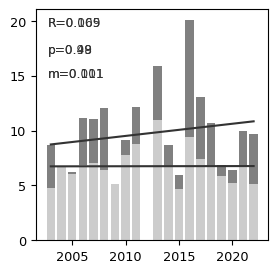

In [16]:
fig, ax = plt.subplots(figsize=(3,3))

include = np.array([], dtype=bool)
for yr in yrs:
    if yr in [2012, 2023,2024]:
        include = np.append(include, False)
    else:
        include = np.append(include, True)
        
        
#========
x = yrs[include]
y = annual_nday_isp[include]
#========
res = stats.linregress(x, y)
print(res)
y_detrend_E = y - (res.intercept + res.slope*x)

ax.bar(x, y, color=[0.5,0.5,0.5])
X = np.array([x.min(), x.max()])
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.745,f'm={res.slope:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)

#========
x = yrs[include]
y = annual_nday_wsp[include]
#========
res = stats.linregress(x, y)
print(res)
y_detrend_E = y - (res.intercept + res.slope*x)

ax.bar(x, y, color=[0.8,0.8,0.8])
X = np.array([x.min(), x.max()])
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.745,f'm={res.slope:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)



In [17]:
-0.268**2

-0.07182400000000001

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


LinregressResult(slope=0.14680971202710333, intercept=-266.41953698475436, rvalue=0.08304683545485421, pvalue=0.7133038357919702, stderr=0.3939253200849376, intercept_stderr=793.1725692780295)
LinregressResult(slope=1.304270462633452, intercept=-2586.14650059312, rvalue=0.5063390119335619, pvalue=0.01917166982807029, stderr=0.509595089884072, intercept_stderr=1026.1114346881068)
LinregressResult(slope=1.2812030075187968, intercept=-2519.821052631579, rvalue=0.4659968370298558, pvalue=0.03836982401195494, stderr=0.5733728958193928, intercept_stderr=1153.9176893855115)
LinregressResult(slope=1.0817774069051838, intercept=8.260074406314118, rvalue=0.7396112334895648, pvalue=0.00012727458641675524, stderr=0.22583686244852683, intercept_stderr=7.128994746165253)


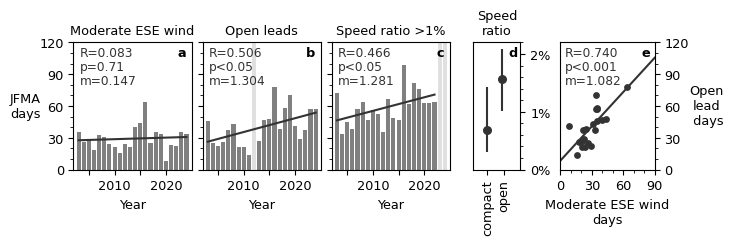

In [19]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, axs = plt.subplots(1, 7, figsize=(7.5,1.65), gridspec_kw={'width_ratios': [1,1,1,0.01,0.4,0.15,0.8]})
axs[3].set_visible(False)
axs[5].set_visible(False)
plt.subplots_adjust(wspace=0.15)

# fig, axs = plt.subplots(4,1, figsize=(3.2,7), gridspec_kw={'height_ratios': [1,1,1,1]})
# plt.subplots_adjust(hspace=0.35)

color='k'
for aa, r, label in zip([0,1,2,4,6], [0.95, 0.95, 0.95, 0.95, 0.95], ['a','b','c','d', 'e'], ):
    axs[aa].text(r,0.975,label,transform=axs[aa].transAxes, weight='bold',ha='right', va='top')
    


for aa in [0,1,2]:
    ax = axs[aa]
    ax.set_ylim(0,120)
    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    
    ax.set_xlim(2002,2025)
    ax.set_xticks([2005,2010,2015,2020])
    ax.set_xticklabels(['',2010,'',2020])
    ax.set_xlabel('Year', fontsize=FS)

    if aa != 0:
        ax.set_yticklabels([])
    
ax = axs[0]
# ax.set_ylabel('Open days', rotation=0, va = 'center', labelpad=25, fontsize=FS)
ax.set_ylabel('JFMA\ndays', rotation=0, va = 'center', labelpad=10, fontsize=FS)
ax.set_title('Moderate ESE wind', weight='normal', fontsize=FS)
# ax.set_title('SE wind ${\mathbf{>5\;ms^{-1}}}$', weight='bold', fontsize=FS-0.5)
# ax.set_title('Open extent > $10^{3} \mathrm{km^{2}}$', fontsize=FS)
#========
x = yrs
y = num_SEdir
#========
res = stats.linregress(x, y)
print(res)
y_detrend_E = y - (res.intercept + res.slope*x)

ax.bar(x, y, color=[0.5,0.5,0.5])
X = np.array([x.min(), x.max()])
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.745,f'm={res.slope:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)



ax = axs[1]
# ax.set_ylabel('Open days', rotation=0, va = 'center', labelpad=25, fontsize=FS)
ax.set_title('Open leads', weight='normal', fontsize=FS)
# ax.set_title('Open extent > $10^{3} \mathrm{km^{2}}$', fontsize=FS)
#========

include = np.array([], dtype=bool)
for yr in yrs:
    if yr in [2012]:
        include = np.append(include, False)
    else:
        include = np.append(include, True)
x = yrs[include]
y = num_open[include]
#========
res = stats.linregress(x, y)
print(res)
y_detrend_open = y - (res.intercept + res.slope*x)

ax.bar(2012, 120, color='lightgray', alpha=0.7)
ax.bar(x, y, color=[0.5,0.5,0.5])
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.745,f'm={res.slope:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)


ax = axs[2]

# ax.set_title('$\mathrm{|{u_{ice}(u_{wind})^{-1}}|}$ > 1%', fontsize=FS)
ax.set_title('Speed ratio >1%', weight='normal', fontsize=FS)
# ax.set_ylabel('$\mathrm{|{u_{ice}(u_{wind})^{-1}}|}$', rotation=0, va = 'center', labelpad=15, fontsize=FS)
# ax.set_ylabel('High\nice-wind\nspeed ratio\ndays', rotation=0, va = 'center', labelpad=25, fontsize=FS)
#========
include = np.array([], dtype=bool)
for yr in yrs:
    if yr in [2023,2024]:
        include = np.append(include, False)
    else:
        include = np.append(include, True)
x = yrs[include]
y = num_wf[include]
#========

res = stats.linregress(x, y)
print(res)
y_detrend_wf = y - (res.intercept + res.slope*x)

ax.bar(2023, 120, color='lightgray', alpha=0.7)
ax.bar(2024, 120, color='lightgray', alpha=0.7)
ax.bar(x, y, color=[0.5,0.5,0.5])
X = np.array([x.min(), x.max()])
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.745,f'm={res.slope:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)

ax = axs[6]
color = 'k'
ax.set_xlim(0,90)
ax.set_ylim(0,120)
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.xaxis.set_minor_locator(MultipleLocator(10))

ax.yaxis.set_major_locator(MultipleLocator(30))
ax.yaxis.set_minor_locator(MultipleLocator(10))

# ax.set_xticks([-30,0,30,])
# ax.set_yticks([-30,0,30,])

ax.text(1.55,0.5,'Open\nlead\n days', c='k',transform=ax.transAxes, ha='center', va='center')
# ax.set_ylabel('Open\nlead\n days', rotation=0, loc = 'center', labelpad=20, size = FS)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
# ax.set_xlabel('Speed ratio > 1%', rotation=0,)
ax.set_xlabel('Moderate ESE wind\ndays', rotation=0, size = FS)
# ax.text(1.55,0.9, 'Detrended\nJFMA days:', c='k', transform=ax.transAxes, ha='center', va='top')
# ax.text(1.6,0.85, 'Speed\nratio>1%\ndays', c='k', transform=ax.transAxes, ha='center', va='top')
# ax.text(1.6,0.3, 'Open lead\ndays', c='b', transform=ax.transAxes, ha='center', va='top')

# x = y_detrend_E
# y = y_detrend_wf
# yrs_crop = yrs[yrs!=2012]

# res = stats.linregress(x, y)
# print(res)
# ax.scatter(x, y, c=[0.3,0.3,0.3], marker='o', s = 15)
# X = np.array(ax.get_xlim())
# # ax.plot(X, X, c='lightgray', zorder=-1)
# ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
# ax.text(0.05,0.95,f'Speed ratio >1%',c=[0.2,0.2,0.2],weight='normal', transform=ax.transAxes, ha='left', va='top', size = FS-0.75)
# ax.text(0.05,0.825,f'R={res.rvalue:.3f}', c=[0.2,0.2,0.2],transform=ax.transAxes, ha='left', va='top', size = FS-0.75)
# ax.text(0.05,0.71,list_pvalue(res.pvalue), c=[0.2,0.2,0.2],transform=ax.transAxes, ha='left', va='top', size = FS-0.75)

# ax.text(0.99,0.175,f'R={res.rvalue:.3f}', c='k', transform=ax.transAxes, ha='right', va='bottom', size = FS-1.5)
# ax.text(0.99,0.025,list_pvalue(res.pvalue), c='k', transform=ax.transAxes, ha='right', va='bottom', size = FS-1.5)

yrs_crop = yrs[yrs!=2012]
x = num_SEdir[yrs!=2012]
y = num_open[yrs!=2012]
color = 'k'
res = stats.linregress(x, y)
print(res)
# ax2 = ax.twinx()
# ax2.set_ylim(-30,60)

ax.scatter(x, y, c=[0.2,0.2,0.2], marker='o',s = 15)
X = np.array(ax.get_xlim())
# ax.plot(X, X, c='lightgray', zorder=-1)
color = [0.2,0.2,0.2]
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')
# ax.text(0.975,0.02,'Moderate SE wind', c=color, weight='normal', transform=ax.transAxes, ha='right', va='bottom', size = FS-0.75)
# ax.text(0.975,-0.01,'SE wind${\mathbf{>5\;ms^{-1}}}$', c=color, weight='bold', transform=ax.transAxes, ha='right', va='bottom', size = FS-0.75)
# ax.text(0.975,0.2,'${\mathbf{>5\;ms^{-1}}}$', c=color, weight='bold', transform=ax.transAxes, ha='right', va='bottom', size = FS-0.75)
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.745,f'm={res.slope:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)



ax = axs[4]
ax.set_title('Speed\nratio', weight='normal', fontsize=FS)
ax.yaxis.tick_right()
ax.set_xlim(0,1)
ax.set_ylim(0,2.2)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.set_yticks([0,1,2])
ax.set_yticklabels(['0%', '1%', '2%'])
ax.set_xticks([0.3,0.65])
ax.set_xticklabels(['compact', 'open'], rotation=90)
def plot_range(ax, x, ydata, color):
    ax.scatter(x, np.nanmedian(ydata), s=30, c=[0.2,0.2,0.2])
    ax.vlines(x, np.nanpercentile(ydata, 25), np.nanpercentile(ydata, 75), colors=[0.2,0.2,0.2])    
    
plot_range(ax, 0.3, all_close_ratio, 'k')
plot_range(ax, 0.6, all_open_ratio, 'k')



# ax.text(0.05,0.975,f'R={res.rvalue:.3f}', transform=ax.transAxes, c='b', ha='left', va='top', size = FS-1.25)
# ax.text(0.05,0.875,list_pvalue(res.pvalue), transform=ax.transAxes, c='b', ha='left', va='top', size = FS-1.25)


# ax2.set_ylabel('Open\nJFMA days', c=color, rotation=0, va = 'center', labelpad=20)
# ax2.set_xticks([])
# ax2.set_xticklabels([-30,0,30,60], c=color)
# axyaxis.tick_right()
# ax.yaxis.set_label_position("right")

# fig.savefig('./figures/longterm_context_Jan-Apr.png', dpi=300, bbox_inches='tight', pad_inches=0)


In [161]:
0.739611233**2

0.5470247759797803

In [512]:
(num_open/(num_open+num_close))[yrs==2021]

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_49599/439365698.py:1: RuntimeWarning: invalid value encountered in divide
  (num_open/(num_open+num_close))[yrs==2021]


array([0.24166667])

In [498]:
np.nanmedian(num_open/num_SE)

1.013157894736842

In [499]:
num_open[yrs==2021]/num_SE[yrs==2021]

array([0.76315789])

<BarContainer object of 22 artists>

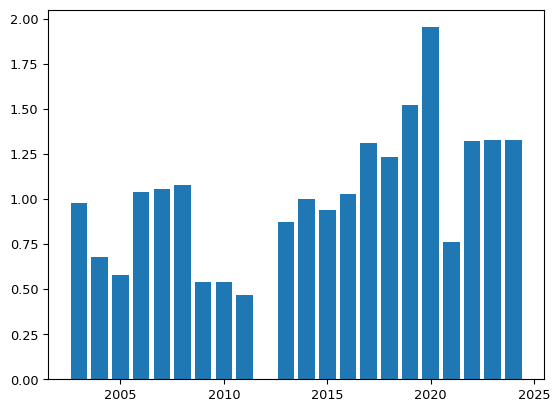

In [497]:
plt.bar(yrs, num_open/num_SE)

In [417]:
np.nanmean(num_open/(num_open+num_close))

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_49599/2056051374.py:1: RuntimeWarning: invalid value encountered in divide
  np.nanmean(num_open/(num_open+num_close))


0.3333267742358651

In [441]:
print(len(yrs[yrs>2013]))
print(len(yrs[yrs<=2013]))

11
11


In [443]:
print(np.nanmean(num_open[yrs>2013]))
print(np.nanstd(num_open[yrs>2013]))

50.90909090909091
14.093548139966519


In [449]:
print(np.nanmean(num_open[yrs<=2013][yrs[yrs<=2013]!=2012]))
print(np.nanstd(num_open[yrs<=2013][yrs[yrs<=2013]!=2012]))

28.2
9.867117106835208


In [450]:
50.9/28.2

1.804964539007092

In [420]:
np.nanmedian(all_close_ratio)

0.68992095829146

In [421]:
np.nanmedian(all_open_ratio)

1.5734136486907586

In [345]:
np.nanmedian(np.append(all_close_ratio, all_open_ratio))

0.9946913840765157

In [344]:
np.nanmedian(all_open_ratio)/np.nanmedian(all_close_ratio)

2.2805708824779076

In [164]:
bins = np.arange(-16,17,2)
width = (bins[1]-bins[0])/2

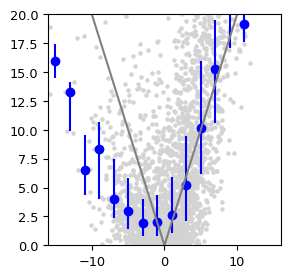

In [180]:
all_SE = np.append(close_all_SE, open_all_SE)
all_RA = np.append(all_close_ratio, all_open_ratio)
all_ICE = np.append(close_all_ice, open_all_ice)
all_WNW = np.append(close_all_WNW, open_all_WNW)

fig, ax = plt.subplots(figsize=(3,3))
plt.ylim(0,20)
ax.set_xlim(-16,16)

plt.scatter(all_SE, all_ICE, c='lightgray', s=5)

for bb in range(len(bins)-1):
    
    x = bins[bb]+width
    ydata = all_ICE[(all_SE>bins[bb])&(all_SE<bins[bb+1])]
    
    plot_range(x, ydata, 'blue')
    
# ax.plot([ax.get_xlim()[0],0], [-2*ax.get_xlim()[0],0], c='gray')
# ax.plot([0,ax.get_xlim()[-1]], [0,2*ax.get_xlim()[-1]], c='gray')
    
ax.plot(np.array(ax.get_xlim()), 2*np.array(ax.get_xlim()), c='gray')
ax.plot(-np.array(ax.get_xlim()), 2*np.array(ax.get_xlim()), c='gray')

# plt.scatter(all_SE[np.abs(all_SE)>0.5], all_RA[np.abs(all_SE)>0.5])



In [175]:
2*np.array(ax.get_xlim())

array([-32.,  32.])

In [158]:
ax.get_xlim()[0]

-20.0

In [84]:
np.nanmedian(all_close_ratio)

0.68992095829146

LinregressResult(slope=0.952558909380701, intercept=-6.3876117639532e-14, rvalue=0.6253710464314461, pvalue=0.003190503594225871, stderr=0.2801526595747179, intercept_stderr=1.5820360571471932)
LinregressResult(slope=1.09567146068296, intercept=-0.34487419067148445, rvalue=0.6612666922098688, pvalue=0.0020492348415729364, stderr=0.3014587342501776, intercept_stderr=1.696897803782507)


Text(0.05, 0.85, 'p<0.01')

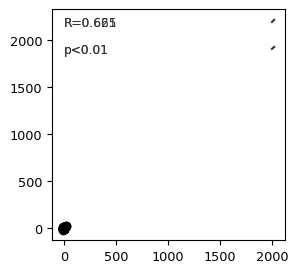

In [40]:
fig, ax = plt.subplots(figsize=(3,3))
#========
x = y_detrend_E
y = y_detrend_ice
#========
res = stats.linregress(x, y)
print(res)
ax.scatter(x, y, color='k')
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)


#========
x = y_detrend_E[yrs!=2012]
y = y_detrend_open
#========
res = stats.linregress(x, y)
print(res)
ax.scatter(x, y, color='k')
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)


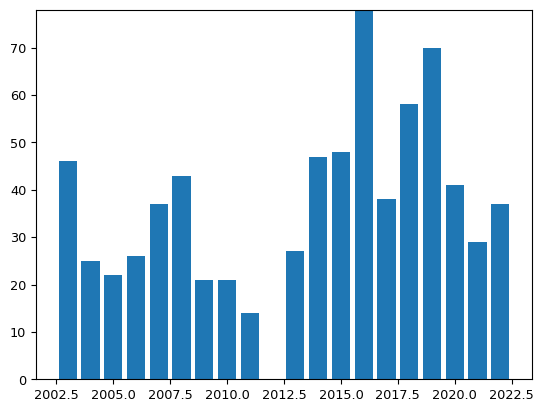

In [56]:
time_range = slice(datetime(2003,1,1), datetime(2022,4,30))

ds3 = xr.open_dataset('./data/SBS_open_area_JFMA_2003-2024_n6250.nc').sel(time=time_range)
ds4 = xr.open_dataset('./data/SBS_wind_JFMA_2003-2024_with2012.nc').sel(time=time_range)
ds5 = xr.open_dataset('./data/SBS_drift_JFMA_2003-2022_with2012.nc').sel(time=time_range)

years = np.array([date.year for date in pd.to_datetime(ds3.time.values)])
months = np.array([date.month for date in pd.to_datetime(ds3.time.values)])

years3 = np.array([date.year for date in pd.to_datetime(ds4.time.values)])
months3 = np.array([date.month for date in pd.to_datetime(ds4.time.values)])
# yrs = np.array(list(set(years))) 

# yrs = np.append(np.arange(2003,2012), np.arange(2013,2023))
# 
yrs = np.arange(2003,2023)

mean_open = np.array([])
median_open = np.array([])
num_open = np.array([])
num_close = np.array([])
mean_u10 = np.array([])
mean_v10 = np.array([])
num_SE = np.array([])
num_ESE = np.array([])
num_E = np.array([])

mean_SE = np.array([])

mean_u = np.array([])
mean_v = np.array([])
num_WNW = np.array([])
mean_NW = np.array([])
num_NW = np.array([])

ice_speed = np.array([])
wind_speed = np.array([])

# ESE wind
U = -np.cos(-22.5 * np.pi/180)
V = -np.sin(-22.5 * np.pi/180)


U_SE = -np.cos(-45 * np.pi/180)
V_SE = -np.sin(-45 * np.pi/180)

initial_SE = np.array([])
initial_num_SE = np.array([])

mean_wf = np.array([])
num_wf = np.array([])

mean_WNW = np.array([])
mean_SSW = np.array([])
mean_ice_speed = np.array([])
num_mean_wf = np.array([])

all_wf = np.array([])


# first month to include
#=====
M = 1
#=====


for year in yrs:
    
    if year == 2012:
        
        mean_open = np.append(mean_open, np.nan)
        median_open = np.append(median_open, np.nan)
        num_open = np.append(num_open, np.nan)
        num_close = np.append(num_close, np.nan)
        
    else:
        num_open = np.append(num_open, np.sum(ds3.oa_g20[(years == year)&(months>=M)] >= 1000))


    mean_u10 = np.append(mean_u10, np.mean(ds4.u10[(years3==year)&(months3>=M)]))
    mean_v10 = np.append(mean_v10, np.mean(ds4.v10[(years3==year)&(months3>=M)]))
    
    ESE = ds4.u10[(years3==year)&(months3>=M)] * U + ds4.v10[(years3==year)&(months3>=M)] * V
    num_ESE = np.append(num_ESE, np.sum(ESE > 5))
    
    SE = ds4.u10[(years3==year)&(months3>=M)] * U_SE + ds4.v10[(years3==year)&(months3>=M)] * V_SE
#     mean_SE = np.append(mean_SE, np.nanmean(SE[:60]))
    num_SE = np.append(num_SE, np.sum(SE > 5))
    
    num_E = np.append(num_E, np.sum(-ds4.u10[(years3==year)&(months3>=M)] > 5))
    
    WNW = ds5.u[(years3==year)&(months3>=M)] * (U) + ds5.v[(years3==year)&(months3>=M)] * (V)
    num_WNW = np.append(num_WNW, np.sum(WNW > 10))
    mean_WNW = np.append(mean_WNW, np.nanmean(WNW))
    
    
    
    NW = ds5.u[(years3==year)&(months3>=M)] * (U_SE) + ds5.v[(years3==year)&(months3>=M)] * (V_SE)
    num_NW = np.append(num_NW, np.sum(NW>0))
    mean_NW = np.append(mean_NW, np.nanmean(NW))
    
    SPice = np.sqrt(ds5.u[(years3==year)&(months3>=M)]**2 + ds5.v[(years3==year)&(months3>=M)]**2)
    SPair = np.sqrt(ds4.u10[(years3==year)&(months3>=M)]**2 + ds4.v10[(years3==year)&(months3>=M)]**2)
    
    ice_speed = np.append(ice_speed, np.nanmean(SPice))
    wind_speed = np.append(wind_speed, np.nanmean(SPair))

    mean_wf = np.append(mean_wf, np.nanmedian(SPice / SPair))
    
    all_wf = np.append(all_wf, SPice / SPair)
    num_wf = np.append(num_wf, np.nansum(SPice / SPair > 1))
    
    

plt.bar(yrs, num_open)
plt.bar(yrs, num_close, bottom = num_open)

mean_ESE = mean_u10 * U + mean_v10 * V
# mean_WNW = mean_u * (U) + mean_v * (V)



In [57]:
np.nanmean(all_wf)

1.2700919085022355

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


LinregressResult(slope=0.10827067669172928, intercept=-197.1947368421052, rvalue=0.061904874685950614, pvalue=0.7954274857212839, stderr=0.4114489862391319, intercept_stderr=828.0444837256852)
LinregressResult(slope=1.1746634996041174, intercept=-2325.7254156769604, rvalue=0.4188573949526596, pvalue=0.07427272576633541, stderr=0.6176373600481044, intercept_stderr=1243.0168092640572)
LinregressResult(slope=1.2812030075187968, intercept=-2519.821052631579, rvalue=0.4659968370298558, pvalue=0.03836982401195494, stderr=0.5733728958193928, intercept_stderr=1153.9176893855115)
LinregressResult(slope=0.6125722628179089, intercept=1.2083893945390922, rvalue=0.6917675907682054, pvalue=0.0010337839071512837, stderr=0.1550894146443649, intercept_stderr=2.336082896903095)
LinregressResult(slope=0.5385121542296387, intercept=0.5603086664026753, rvalue=0.8096383828335779, pvalue=2.6708481653442285e-05, stderr=0.09468159223054765, intercept_stderr=1.4261711462934583)


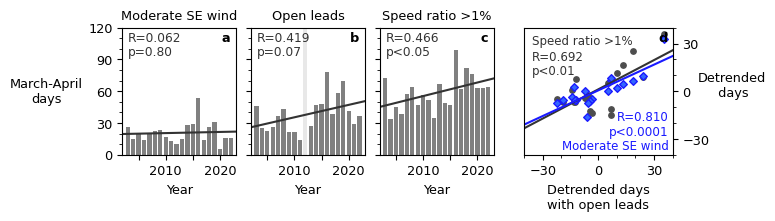

In [65]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, axs = plt.subplots(1, 5, figsize=(7.1,1.65), gridspec_kw={'width_ratios': [1,1,1,0.01,1.3]})
axs[3].set_visible(False)
plt.subplots_adjust(wspace=0.15)

# fig, axs = plt.subplots(4,1, figsize=(3.2,7), gridspec_kw={'height_ratios': [1,1,1,1]})
# plt.subplots_adjust(hspace=0.35)

color='k'
for aa, r, label in zip([0,1,2,4], [0.95, 0.95, 0.95, 0.965], ['a','b','c','d'], ):
    axs[aa].text(r,0.975,label,transform=axs[aa].transAxes, weight='bold',ha='right', va='top')
    

# X = np.array(ax.get_xlim())
X = np.array([yrs[0]-1, yrs[-1]+1])

for aa in [0,1,2]:
    ax = axs[aa]
    ax.set_ylim(0,120)
    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    
    ax.set_xlim(2002,2023)
    ax.set_xticks([2005,2010,2015,2020])
    ax.set_xticklabels(['',2010,'',2020])
    ax.set_xlabel('Year', fontsize=FS)

    if aa != 0:
        ax.set_yticklabels([])
    
ax = axs[0]
# ax.set_ylabel('Open days', rotation=0, va = 'center', labelpad=25, fontsize=FS)
ax.set_ylabel('March-April\ndays', rotation=0, va = 'center', labelpad=30, fontsize=FS)
ax.set_title('Moderate SE wind', weight='normal', fontsize=FS)
# ax.set_title('SE wind ${\mathbf{>5\;ms^{-1}}}$', weight='bold', fontsize=FS-0.5)
# ax.set_title('Open extent > $10^{3} \mathrm{km^{2}}$', fontsize=FS)
#========
x = yrs
y = num_SE
#========
res = stats.linregress(x, y)
print(res)
y_detrend_E = y - (res.intercept + res.slope*x)

ax.bar(x, y, color=[0.5,0.5,0.5])
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)



ax = axs[1]
# ax.set_ylabel('Open days', rotation=0, va = 'center', labelpad=25, fontsize=FS)
ax.set_title('Open leads', weight='normal', fontsize=FS)
# ax.set_title('Open extent > $10^{3} \mathrm{km^{2}}$', fontsize=FS)
#========
x = yrs[yrs!=2012]
y = num_open[yrs!=2012]
#========
res = stats.linregress(x, y)
print(res)
y_detrend_open = y - (res.intercept + res.slope*x)

ax.bar(2012, 120, color='lightgray', alpha=0.5)
ax.bar(x, y, color=[0.5,0.5,0.5])
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)


ax = axs[2]

# ax.set_title('$\mathrm{|{u_{ice}(u_{wind})^{-1}}|}$ > 1%', fontsize=FS)
ax.set_title('Speed ratio >1%', weight='normal', fontsize=FS)
# ax.set_ylabel('$\mathrm{|{u_{ice}(u_{wind})^{-1}}|}$', rotation=0, va = 'center', labelpad=15, fontsize=FS)
# ax.set_ylabel('High\nice-wind\nspeed ratio\ndays', rotation=0, va = 'center', labelpad=25, fontsize=FS)
#========
x = yrs
y = num_wf
#========

res = stats.linregress(x, y)
print(res)
y_detrend_wf = y - (res.intercept + res.slope*x)

ax.bar(x, y, color=[0.5,0.5,0.5])
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.965,f'R={res.rvalue:.3f}', transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)
ax.text(0.05,0.85,list_pvalue(res.pvalue), transform=ax.transAxes, color=[0.2,0.2,0.2], ha='left', va='top', size = FS-0.5)

ax = axs[4]
color = 'k'
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.xaxis.set_minor_locator(MultipleLocator(10))

ax.yaxis.set_major_locator(MultipleLocator(30))
ax.yaxis.set_minor_locator(MultipleLocator(10))

# ax.set_xticks([-30,0,30,])
# ax.set_yticks([-30,0,30,])

ax.text(1.4,0.55,'Detrended\n days', c='k',transform=ax.transAxes, ha='center', va='center')
# ax.set_ylabel('Detrended\nJFMA days', rotation=0, loc = 'center', labelpad=20, size = FS)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
# ax.set_xlabel('Speed ratio > 1%', rotation=0,)
ax.set_xlabel('Detrended days\nwith open leads', rotation=0, size = FS)
# ax.text(1.55,0.9, 'Detrended\nJFMA days:', c='k', transform=ax.transAxes, ha='center', va='top')
# ax.text(1.6,0.85, 'Speed\nratio>1%\ndays', c='k', transform=ax.transAxes, ha='center', va='top')
# ax.text(1.6,0.3, 'Open lead\ndays', c='b', transform=ax.transAxes, ha='center', va='top')

x = y_detrend_open
y = y_detrend_wf[yrs!=2012]
yrs_crop = yrs[yrs!=2012]

res = stats.linregress(x, y)
print(res)
ax.scatter(x, y, c=[0.3,0.3,0.3], marker='o', s = 15)
X = np.array(ax.get_xlim())
# ax.plot(X, X, c='lightgray', zorder=-1)
ax.plot(X, res.intercept + res.slope*X, c=[0.2,0.2,0.2], label='fitted line')
ax.text(0.05,0.95,f'Speed ratio >1%',c=[0.2,0.2,0.2],weight='normal', transform=ax.transAxes, ha='left', va='top', size = FS-0.75)
ax.text(0.05,0.825,f'R={res.rvalue:.3f}', c=[0.2,0.2,0.2],transform=ax.transAxes, ha='left', va='top', size = FS-0.75)
ax.text(0.05,0.71,list_pvalue(res.pvalue), c=[0.2,0.2,0.2],transform=ax.transAxes, ha='left', va='top', size = FS-0.75)

# ax.text(0.99,0.175,f'R={res.rvalue:.3f}', c='k', transform=ax.transAxes, ha='right', va='bottom', size = FS-1.5)
# ax.text(0.99,0.025,list_pvalue(res.pvalue), c='k', transform=ax.transAxes, ha='right', va='bottom', size = FS-1.5)

x = y_detrend_open
y = y_detrend_E[yrs!=2012]
color = [0.2,0.4,1]
res = stats.linregress(x, y)
print(res)
# ax2 = ax.twinx()
# ax2.set_ylim(-30,60)

ax.scatter(x, y, c=color, marker='D', edgecolor=[0.1,0.1,1], s = 15)
X = np.array(ax.get_xlim())
# ax.plot(X, X, c='lightgray', zorder=-1)
color = [0.1,0.1,1]
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')
ax.text(0.975,0.02,'Moderate SE wind', c=color, weight='normal', transform=ax.transAxes, ha='right', va='bottom', size = FS-0.75)
# ax.text(0.975,-0.01,'SE wind${\mathbf{>5\;ms^{-1}}}$', c=color, weight='bold', transform=ax.transAxes, ha='right', va='bottom', size = FS-0.75)
# ax.text(0.975,0.2,'${\mathbf{>5\;ms^{-1}}}$', c=color, weight='bold', transform=ax.transAxes, ha='right', va='bottom', size = FS-0.75)
ax.text(0.975,0.25,f'R={res.rvalue:.3f}', c=color, transform=ax.transAxes, ha='right', va='bottom', size = FS-0.75)
ax.text(0.975,0.13,list_pvalue(res.pvalue), c=color, transform=ax.transAxes, ha='right', va='bottom', size = FS-0.57)

# ax.text(0.05,0.975,f'R={res.rvalue:.3f}', transform=ax.transAxes, c='b', ha='left', va='top', size = FS-1.25)
# ax.text(0.05,0.875,list_pvalue(res.pvalue), transform=ax.transAxes, c='b', ha='left', va='top', size = FS-1.25)


# ax2.set_ylabel('Open\nJFMA days', c=color, rotation=0, va = 'center', labelpad=20)
# ax2.set_xticks([])
# ax2.set_xticklabels([-30,0,30,60], c=color)
# axyaxis.tick_right()
# ax.yaxis.set_label_position("right")

fig.savefig('./figures/longterm_context_2.png', dpi=300, bbox_inches='tight', pad_inches=0)


In [465]:

dates = np.array([], dtype='datetime64')
year = np.array([])
T2M = np.array([])

for year in np.arange(2003, 2024):
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/T2m/ERA5_T2m_{year}_hourly.nc')
    ds_crop = (ds.sel(latitude=slice(74,70), longitude=slice(210,240)).mean(dim='longitude').mean(dim='latitude')).resample(time='1D').mean()
    dates = np.append(dates, ds_crop.sel(time=slice(datetime(year,1,1), datetime(year,4,30))).time)
    T2M = np.append(T2M, ds_crop.sel(time=slice(datetime(year,1,1), datetime(year,4,30))).t2m - 273.15)

# ds.resample(time='1D').mean()

/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/xarray/core/groupby.py:345: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/xarray/core/groupby.py:345: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/xarray/core/groupby.py:345: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/xarray/core/groupby.py:345: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/xa

In [469]:
years = np.array([date.year for date in pd.to_datetime(dates)])
months = np.array([date.month for date in pd.to_datetime(dates)])



In [473]:

temps = {}
temps['J'] = np.array([])
temps['F'] = np.array([])
temps['M'] = np.array([])
temps['A'] = np.array([])

for year in np.arange(2003, 2023):
    temps['J'] = np.append(temps['J'], np.nanmean(T2M[(years == year)&(months==1)]))
    temps['F'] = np.append(temps['F'], np.nanmean(T2M[(years == year)&(months==2)]))
    temps['M'] = np.append(temps['M'], np.nanmean(T2M[(years == year)&(months==3)]))
    temps['A'] = np.append(temps['A'], np.nanmean(T2M[(years == year)&(months==4)]))

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_49599/3365593859.py:8: RuntimeWarning: Mean of empty slice
  temps['J'] = np.append(temps['J'], np.nanmean(T2M[(years == year)&(months==1)]))
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_49599/3365593859.py:9: RuntimeWarning: Mean of empty slice
  temps['F'] = np.append(temps['F'], np.nanmean(T2M[(years == year)&(months==2)]))
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_49599/3365593859.py:10: RuntimeWarning: Mean of empty slice
  temps['M'] = np.append(temps['M'], np.nanmean(T2M[(years == year)&(months==3)]))
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_49599/3365593859.py:11: RuntimeWarning: Mean of empty slice
  temps['A'] = np.append(temps['A'], np.nanmean(T2M[(years == year)&(months==4)]))


In [474]:
temps['A']

array([-13.01980794, -16.61042074, -13.78860321, -16.37025655,
       -12.45941315, -13.15866547, -14.37540487,  -8.68177592,
       -16.62061157, -13.95714518, -16.14217834, -14.42618408,
       -13.939711  , -14.62539673, -15.98155721, -16.12279714,
       -14.86169281, -13.97360331, -15.97618408,          nan])

J
LinregressResult(slope=0.024148145070100196, intercept=-72.60072567070263, rvalue=0.07892632206613073, pvalue=0.748076037021508, stderr=0.07397424309345538, intercept_stderr=148.83672860084664)

F
LinregressResult(slope=0.04862013492018831, intercept=-122.28806537044312, rvalue=0.08431841368613474, pvalue=0.73145115016351, stderr=0.13935415702085555, intercept_stderr=280.38160284667833)

M
LinregressResult(slope=0.21062493057121448, intercept=-446.29149204636275, rvalue=0.4362418642764824, pvalue=0.061867567498292975, stderr=0.1053702900929082, intercept_stderr=212.00580922926883)

A
LinregressResult(slope=-0.07845730430201477, intercept=143.3776010292454, rvalue=-0.2310770407811, pvalue=0.3411836336328843, stderr=0.080119117061114, intercept_stderr=161.2002608353756)



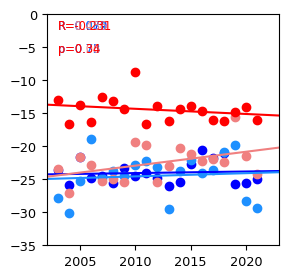

In [477]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(2002,2023)
ax.set_ylim(-35,0)
X = np.array(ax.get_xlim())

x = yrs[:-3]

for color, mon in zip(['blue', 'dodgerblue', 'lightcoral', 'r'], ['J', 'F', 'M', 'A']):
    y = temps[mon][:-1]
    res = stats.linregress(x, y)
    print(mon)
    print(res)
    print()
    ax.scatter(x, y, c=color)
    ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')
    ax.text(0.05,0.975,f'R={res.rvalue:.3f}',  c=color,transform=ax.transAxes, ha='left', va='top', size = FS-1)
    ax.text(0.05,0.875,list_pvalue(res.pvalue),  c=color,transform=ax.transAxes, ha='left', va='top', size = FS-1)




*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


LinregressResult(slope=0.06608381313459982, intercept=-151.4569455085586, rvalue=0.21072646796430228, pvalue=0.3865115607643125, stderr=0.07435126018757152, intercept_stderr=149.59528980496674)


Text(0.05, 0.875, 'p=0.39')

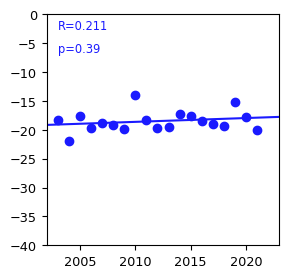

In [1705]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(2002,2023)
ax.set_ylim(-40,0)
X = np.array(ax.get_xlim())

x = yrs[:-1]
y = (temps['M'][:-1] + temps['A'][:-1])/2
res = stats.linregress(x, y)
print(res)
ax.scatter(x, y, c=color)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')
ax.text(0.05,0.975,f'R={res.rvalue:.3f}',  c=color,transform=ax.transAxes, ha='left', va='top', size = FS-1)
ax.text(0.05,0.875,list_pvalue(res.pvalue),  c=color,transform=ax.transAxes, ha='left', va='top', size = FS-1)


In [1677]:
Jan_temps

array([-23.55700093, -25.82525832, -21.66569667, -24.79298253,
       -24.47068491, -25.49401511, -23.28938983, -24.47854319,
       -23.99230416, -24.87065026, -25.9607411 , -25.42666971,
       -22.73239579, -20.5175353 , -21.83746239, -21.01716171,
       -25.75861629, -25.58906457, -25.00232524,          nan])

In [1623]:
print(np.nanmean(num_open[yrs<2012]))
print(np.nanstd(num_open[yrs<2012]))

7.0
5.354126134736337


In [1365]:
print(np.nanmean(num_open[yrs>2012]))
print(np.nanstd(num_open[yrs>2012]))

47.3
15.975293424535275


In [14]:
ds1 = xr.open_dataset('./data/SBS_open_area_v2.nc')
OE_1km = ds1.sel(time=slice(datetime(2021,3,1), datetime(2021,4,30))).oa_g20

In [15]:
ds2 = xr.open_dataset('./data/SBS_open_area_JFMA_2003-2024_n6250.nc')
OE_6km = ds2.sel(time=slice(datetime(2021,3,1), datetime(2021,4,30))).oa_g20

LinregressResult(slope=1.000456604445955, intercept=1.172798449878428, rvalue=0.9999991320115084, pvalue=1.205634362118234e-171, stderr=0.00017161075966364361, intercept_stderr=0.8258094425749785)


2.9657367974007958

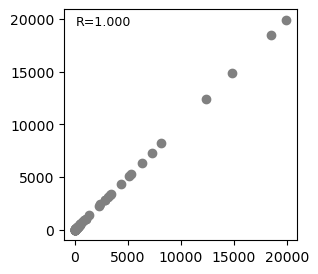

In [16]:
from scipy import stats
FS = 10
fig, ax =plt.subplots(figsize=(3,3))

x = OE_1km
y = OE_6km

res = stats.linregress(x, y)
print(res)
y_detrend_wf = y - (res.intercept + res.slope*x)

ax.scatter(x, y, color=[0.5,0.5,0.5])
# ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')
ax.text(0.05,0.975,f'R={res.rvalue:.3f}', transform=ax.transAxes, ha='left', va='top', size = FS-1)
# ax.text(0.05,0.875,list_pvalue(res.pvalue), transform=ax.transAxes, ha='left', va='top', size = FS-1)

np.nanmean(np.abs(OE_1km - OE_6km))

In [19]:
(2.96 / (.3 * 10 **5))*100

0.009866666666666666

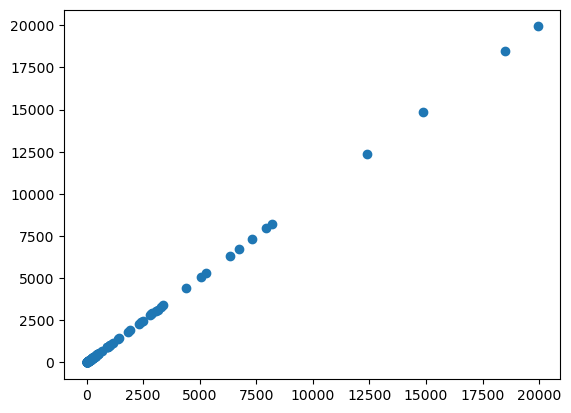

In [1375]:
plt.scatter(OE_1km, OE_6km, )

In [1313]:
ds6 = xr.open_dataset('./data/SBS_MYI_2003-2024_with2012.nc')
ds6.close()

years = np.array([date.year for date in pd.to_datetime(ds6.time.values)])

annual_MYIF = np.array([np.nanmean(ds6.MYI.values[years==year]/ds6.total.values[years==year]) for year in yrs])

# num_MYIF = np.array([np.nansum(ds6.MYI.values[years==year]/ds6.total.values[years==year] > 0.25) for year in yrs])

first_MYIF = np.array([(ds6.MYI.values[years==year]/ds6.total.values[years==year])[0] for year in yrs])
last_MYIF = np.array([(ds6.MYI.values[years==year]/ds6.total.values[years==year])[-1] for year in yrs])
middle_MYIF = np.array([(ds6.MYI.values[years==year]/ds6.total.values[years==year])[9] for year in yrs])



initial_MYIF = np.array([np.nanmean((ds6.MYI.values[years==year]/ds6.total.values[years==year])[:9]) for year in yrs])
final_MYIF = np.array([np.nanmean((ds6.MYI.values[years==year]/ds6.total.values[years==year])[9:]) for year in yrs])


ds6


<xarray.Dataset>
Dimensions:  (time: 378)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 2002-01-08 ... 2022-04-30
Data variables:
    MYI      (time) float64 595.0 523.0 373.0 359.0 ... 417.0 383.0 380.0 371.0
    total    (time) float64 1.379e+03 1.379e+03 ... 1.379e+03 1.379e+03
Attributes:
    description:  MYI area in SBS polygon JFMA 2003-2024

In [1231]:
initial_SE[yrs==2021]

array([0.52379646])

LinregressResult(slope=-0.005958877567675409, intercept=0.5240287617117303, rvalue=-0.4899921223267994, pvalue=0.03320034369869187, stderr=0.002571173196938895, intercept_stderr=0.10735265955128219)


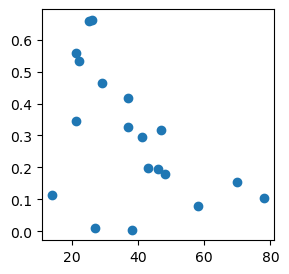

In [1286]:
fig, ax = plt.subplots(figsize=(3,3))

x = num_open[yrs!=2012]
y = annual_MYIF[yrs!=2012]

ax.scatter(x,y)
res = stats.linregress(x, y)
print(res)


# ax.scatter(x[yrs==2021],y[yrs==2021])

LinregressResult(slope=0.6736842105263159, intercept=-1314.5894736842106, rvalue=0.25051329087904894, pvalue=0.2867416453240744, stderr=0.6136425526556634, intercept_stderr=1234.9607064302058)


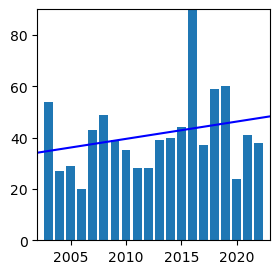

LinregressResult(slope=-0.0003756672318940918, intercept=0.7240868669134732, rvalue=-0.01452271478190549, pvalue=0.9515436020449647, stderr=0.006096399950470462, intercept_stderr=12.269055261783253)


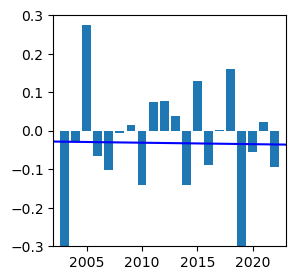

LinregressResult(slope=0.02643329333095157, intercept=-51.92695562493524, rvalue=0.4883927165611635, pvalue=0.028896012490104726, stderr=0.011131994204141373, intercept_stderr=22.4032302955979)


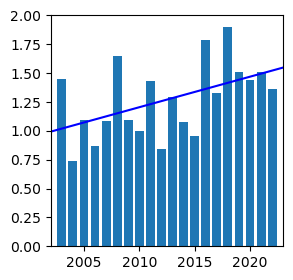

LinregressResult(slope=-0.20658501979566482, intercept=-3.0401081506166616e-15, rvalue=-0.11313560547684225, pvalue=0.6348516769076477, stderr=0.42762778448397515, intercept_stderr=0.06377808035456735)


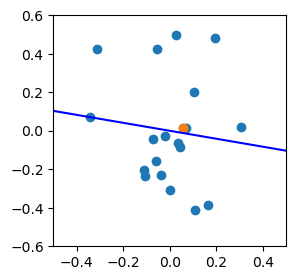

LinregressResult(slope=-0.024314724151065358, intercept=-0.007536851052546719, rvalue=-0.43736282176507985, pvalue=0.0538024956617588, stderr=0.011783889145735556, intercept_stderr=0.01615083674461272)


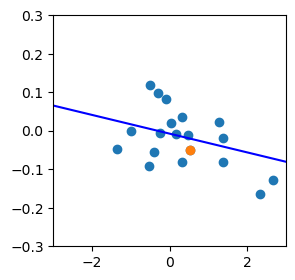

In [1340]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(2002,2023)
ax.set_ylim(0,90)
X = np.array(ax.get_xlim())
x = yrs
y = num_WNW
res = stats.linregress(x, y)
print(res)
y_detrend_wnw = y - (res.intercept + res.slope*x)
ax.bar(x,y)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')
plt.show()


fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(2002,2023)
ax.set_ylim(-0.3,0.3)
X = np.array(ax.get_xlim())
x = yrs
y = last_MYIF - first_MYIF#annual_MYIF
res = stats.linregress(x, y)
print(res)
y_detrend_my = y - (res.intercept + res.slope*x)
ax.bar(x,y)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')
plt.show()


fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(2002,2023)
ax.set_ylim(0,2)
X = np.array(ax.get_xlim())
x = yrs
y = mean_wf
res = stats.linregress(x, y)
print(res)
y_detrend_meanwf = y - (res.intercept + res.slope*x)
ax.bar(x,y)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')
plt.show()

fig, ax = plt.subplots(figsize=(3,3))
x = y_detrend_my 
y = y_detrend_meanwf
res = stats.linregress(x, y)
print(res)

ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.6,0.6)
X = np.array(ax.get_xlim())
ax.scatter(x,y)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')

ax.scatter(x[yrs==2021], y[yrs==2021])
plt.show()


fig, ax = plt.subplots(figsize=(3,3))
x = initial_SE
y = final_MYIF - initial_MYIF
res = stats.linregress(x, y)
print(res)

ax.set_xlim(-3,3)
ax.set_ylim(-0.3,0.3)
X = np.array(ax.get_xlim())
ax.scatter(x,y)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')

ax.scatter(x[yrs==2021], y[yrs==2021])

LinregressResult(slope=0.03447378261267831, intercept=-68.38515087172381, rvalue=0.560593051886789, pvalue=0.012534834254182763, stderr=0.01235079922151147, intercept_stderr=24.856415808442165)


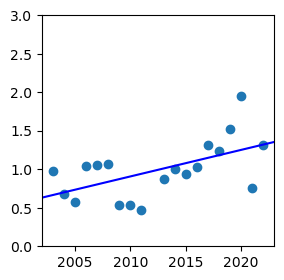

In [1355]:
fig, ax = plt.subplots(figsize=(3,3))
x = yrs[yrs!=2012]
y = (num_open/num_SE)[yrs!=2012]
res = stats.linregress(x, y)
print(res)

ax.set_xlim(2002,2023)
ax.set_ylim(0,3)
X = np.array(ax.get_xlim())
ax.scatter(x,y)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')



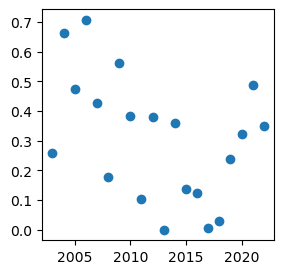

In [1358]:
fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(yrs, initial_MYIF)

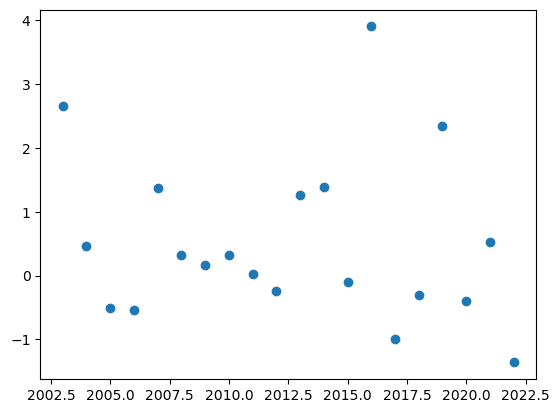

In [1287]:
plt.scatter(yrs, initial_SE)

In [1115]:
ds6 = xr.open_dataset('./data/SBS_MYI_2003-2024_with2012.nc')
ds6.close()

for year in yrs:
    
    ds6

<xarray.Dataset>
Dimensions:  (time: 378)
Coordinates:
  * time     (time) datetime64[ns] 2002-01-01 2002-01-08 ... 2022-04-30
Data variables:
    MYI      (time) float64 ...
    total    (time) float64 ...
Attributes:
    description:  MYI area in SBS polygon JFMA 2003-2024

In [1072]:
x = num_wf[yrs!=2012]
y = num_open[yrs!=2012]
res = stats.linregress(x, y)
print(res)


LinregressResult(slope=0.8167832167832167, intercept=-10.562237762237757, rvalue=0.7527519129142134, pvalue=0.00019989595676252596, stderr=0.17324358883149593, intercept_stderr=10.700213903869885)


In [1073]:
x = y_detrend_wf[yrs!=2012]
y = y_detrend_open
res = stats.linregress(x, y)
print(res)

LinregressResult(slope=0.7812015474482839, intercept=-0.9439956649338589, rvalue=0.6917675907682054, pvalue=0.0010337839071512837, stderr=0.1977825279840345, intercept_stderr=2.6489031566883283)


LinregressResult(slope=-0.4789473684210527, intercept=1001.3315789473686, rvalue=-0.1953105158136474, pvalue=0.4092548186645768, stderr=0.5668660465371127, intercept_stderr=1140.8226014528)
LinregressResult(slope=1.2812030075187968, intercept=-2519.821052631579, rvalue=0.4659968370298558, pvalue=0.03836982401195494, stderr=0.5733728958193928, intercept_stderr=1153.9176893855115)
LinregressResult(slope=1.1746634996041174, intercept=-2325.7254156769604, rvalue=0.4188573949526596, pvalue=0.07427272576633541, stderr=0.6176373600481044, intercept_stderr=1243.0168092640572)
LinregressResult(slope=0.6125722628179089, intercept=1.2083893945390922, rvalue=0.6917675907682054, pvalue=0.0010337839071512837, stderr=0.1550894146443649, intercept_stderr=2.336082896903095)
LinregressResult(slope=0.6378204353507614, intercept=0.03628808864236028, rvalue=0.6752771500676998, pvalue=0.0015109468035816621, stderr=0.16896302336063318, intercept_stderr=2.5450584747316602)


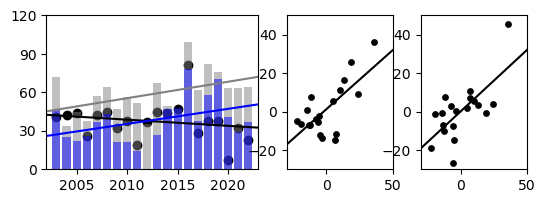

In [926]:
fig, axs = plt.subplots(1, 3, figsize=(6.2,2), gridspec_kw={'width_ratios': [2,1,1]})

YTICKS = [0,30,60,90,120]

# X = np.array(ax.get_xlim())
X = np.array([yrs[0]-1, yrs[-1]+1])

for aa in [0]:
    ax = axs[aa]
    ax.set_ylim(0,120)
    ax.set_xlim(2002,2023)
    ax.set_yticks(YTICKS)

    if aa != 0:
        ax.set_yticklabels([])
    
ax = axs[0]
color = 'k'

x = yrs
y = num_E
res = stats.linregress(x, y)
print(res)
y_detrend_E = y - (res.intercept + res.slope*x)

ax.scatter(x, y, color='k', alpha=1)

ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')



ax = axs[0]
color = 'gray'

x = yrs
y = num_wf

res = stats.linregress(x, y)
print(res)
y_detrend_wf = y - (res.intercept + res.slope*x)

ax.bar(x, y, color='gray', alpha=0.5)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')



ax = axs[0]
color = 'blue'

x = yrs[yrs!=2012]
y = num_open[yrs!=2012]

res = stats.linregress(x, y)
print(res)
y_detrend_open = y - (res.intercept + res.slope*x)

ax.bar(x, y, color='blue', alpha=0.5)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')




ax = axs[1]
color = 'k'
ax.set_xlim(-30,50)
ax.set_ylim(-30,50)
# ax.set_xticks([-30,0,30,60])
# ax.set_yticks([-30,0,30,60])

x = y_detrend_open
y = y_detrend_wf[yrs!=2012]


res = stats.linregress(x, y)
print(res)
ax.scatter(x, y, c=color, marker='o', s = 15)
X = np.array(ax.get_xlim())
# ax.plot(X, X, c='lightgray', zorder=-1)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')


ax = axs[2]
color = 'k'
ax.set_xlim(-30,50)
ax.set_ylim(-30,50)
# ax.set_xticks([-30,0,30,60])
# ax.set_yticks([-30,0,30,60])

x = y_detrend_open
y = y_detrend_E[yrs!=2012]


res = stats.linregress(x, y)
print(res)
ax.scatter(x, y, c=color, marker='o', s = 15)
X = np.array(ax.get_xlim())
# ax.plot(X, X, c='lightgray', zorder=-1)
ax.plot(X, res.intercept + res.slope*X, c=color, label='fitted line')



fig.savefig('./figures/longterm_context.png', dpi=300, bbox_inches='tight', pad_inches=0 )

In [741]:
np.nanpercentile(ice_speed/wind_speed, 50)

1.2208877779169691

In [1013]:
np.nanmedian(ice_speed/wind_speed)

0.9681793059904933

In [278]:
np.nanpercentile(ds3.oa_g20, 50)

182.37977784197386

(-20.0, 20.0)

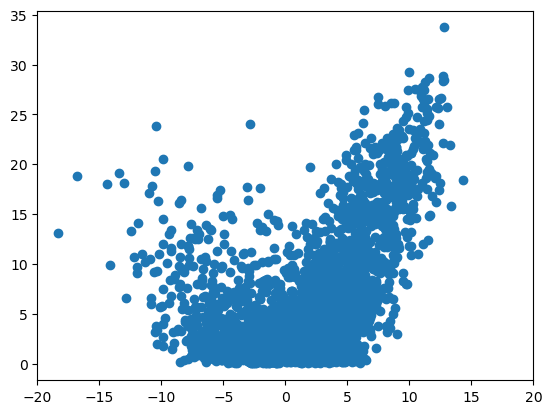

In [1009]:
wind_ESE = ds4.u10*U + ds4.v10*V

wind_speed = np.sqrt(ds4.u10**2 + ds4.v10**2)
ice_speed = np.sqrt(ds5.u**2 + ds5.v**2)
all_open = ds3.oa_g20

plt.scatter(wind_ESE, ice_speed)
plt.xlim(-20,20)
# plt.ylim(-0.1,10)

In [206]:
# y_detrend_open = y_detrend

LinregressResult(slope=0.06560826587915272, intercept=3.912414041210925e-15, rvalue=0.7154241658567144, pvalue=0.000573913745340851, stderr=0.01554015202491821, intercept_stderr=0.02115472744747323)


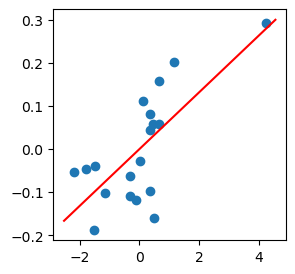

In [210]:
fig, ax = plt.subplots(figsize = (3,3))

x = y_detrend
y = y_detrend_open

res = stats.linregress(x, y)
print(res)

ax.scatter(x, y)

X = np.array(ax.get_xlim())
ax.plot(X, res.intercept + res.slope*X, 'r', label='fitted line')


In [143]:
open_days

array([46., 25., 22., 26., 37., 43., 21., 21., 14., 27., 47., 48., 78.,
       38., 58., 70., 41., 29., 37.])

(-300.0, 300.0)

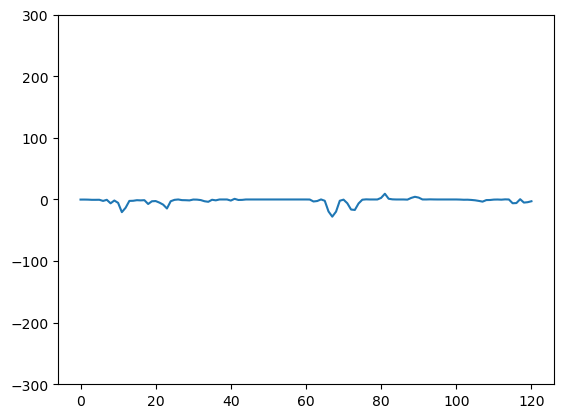

In [19]:
ds1 = xr.open_dataset('./data/SBS_open_area_v2.nc')
ds2 = xr.open_dataset('./data/SBS_open_area_v4.nc')

time_range = slice(datetime(2021, 1, 1), datetime(2021, 5, 1))
plt.plot(ds1.oa_g20.sel(time=time_range) - ds2.oa_g20.sel(time=time_range))
plt.ylim(-300,300)

In [21]:
ds1.oa_g20

<xarray.DataArray 'oa_g20' (time: 212)>
array([24400.494119, 25179.493556, 23624.383898, ..., 27214.593241,
       31294.231046, 25890.902353])
Coordinates:
  * time     (time) datetime64[ns] 2020-11-01 2020-11-02 ... 2021-05-31
Attributes:
    long_name:  net open water area of cells each with OWC >= 20%
    units:      km^2

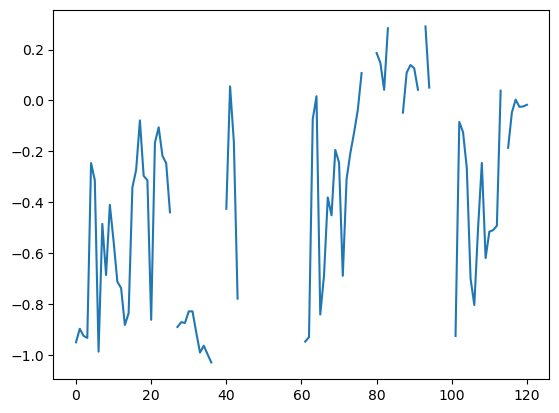

In [27]:
OA1 = ds1.oa_g20.sel(time=time_range)
OA2 = ds2.oa_g20.sel(time=time_range)

FD = (OA1 - OA2) / OA1
PD = 100 * FD 

plt.plot(PD)

LinregressResult(slope=1.4065433733963544, intercept=10.69957725956434, rvalue=0.38888423254762594, pvalue=0.09985663547175552, stderr=0.8081707011279972, intercept_stderr=1.9107455882835356)


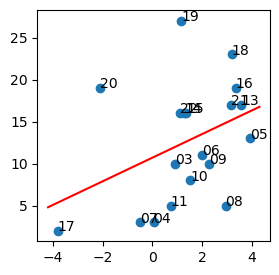

In [67]:
from scipy import stats

df = pd.read_csv('./data/SBS_wind_across_20032022_March.csv')


# ESE wind
U = -np.cos(-22.5 * np.pi/180)
V = -np.sin(-22.5 * np.pi/180)


fig, ax = plt.subplots(figsize=(3,3))

x = df.u.values[df.year!=2012] * U + df.v.values[df.year!=2012] * V
y = df.num_open.values[df.year!=2012]


res = stats.linregress(x, y)
print(res)

ax.scatter(x,y)

X = np.array(ax.get_xlim())
ax.plot(X, res.intercept + res.slope*X, 'r', label='fitted line')

for year, xx, yy in zip(df.year[df.year!=2012], x, y):
    
    ax.text(xx, yy, f'{str(year)[2:]}')


<BarContainer object of 20 artists>

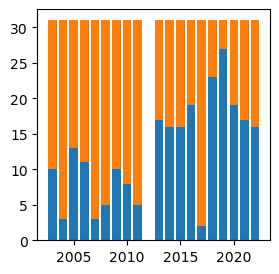

In [64]:
fig, ax = plt.subplots(figsize=(3,3))

ax.bar(df.year, df.num_open)
ax.bar(df.year, df.num_close, bottom=df.num_open)

LinregressResult(slope=-0.9751028918274942, intercept=10.968665459421985, rvalue=-0.32019035925244604, pvalue=0.18140794379719757, stderr=0.6997286728650721, intercept_stderr=1.9953481668078836)


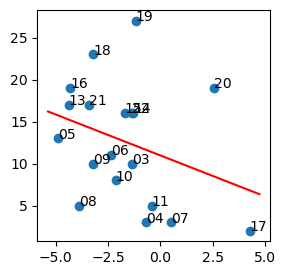

In [72]:
fig, ax = plt.subplots(figsize=(3,3))

x = df.u.values[df.year!=2012]
y = df.num_open.values[df.year!=2012]


res = stats.linregress(x, y)
print(res)

ax.scatter(x,y)

X = np.array(ax.get_xlim())
ax.plot(X, res.intercept + res.slope*X, 'r', label='fitted line')

for year, xx, yy in zip(df.year[df.year!=2012], x, y):
    
    ax.text(xx, yy, f'{str(year)[2:]}')

In [58]:
X 

(-4.1933786053555435, 4.303945781268278)

In [54]:
res.intercept + res.slope*X

NameError: name 'X' is not defined

In [46]:
df

,Unnamed: 0,year,u,v,sp,open_sp,close_sp,num_open,num_close
0,0,2003,-1.361901,-0.898660,5.705005,7.682174,4.763496,10.0,21.0
1,1,2004,-0.695379,-1.549230,5.470454,6.757060,5.332603,3.0,28.0
2,2,2005,-4.906233,-1.607241,6.764390,8.303532,5.652788,13.0,18.0
3,3,2006,-2.343653,-0.479718,5.114447,7.714847,3.684228,11.0,20.0
4,4,2007,0.510826,-0.035767,4.659026,8.213147,4.278226,3.0,28.0
5,5,2008,-3.899574,-1.716615,5.929129,5.739064,5.965680,5.0,26.0
6,6,2009,-3.194963,-1.731493,6.305904,9.797795,4.643098,10.0,21.0
7,7,2010,-2.127281,-1.169975,5.240551,7.233881,4.547219,8.0,23.0
8,8,2011,-0.408789,0.923051,4.596241,6.133939,4.300529,5.0,26.0
9,9,2012,-1.329212,-2.153515,5.079762,NaN,NaN,0.0,0.0


In [55]:
x[-1]

KeyError: -1

In [32]:
df

,Unnamed: 0,year,u,v,sp,open_sp,close_sp,num_open,num_close
0,0,2003,-1.361901,-0.898660,5.705005,7.682174,4.763496,10.0,21.0
1,1,2004,-0.695379,-1.549230,5.470454,6.757060,5.332603,3.0,28.0
2,2,2005,-4.906233,-1.607241,6.764390,8.303532,5.652788,13.0,18.0
3,3,2006,-2.343653,-0.479718,5.114447,7.714847,3.684228,11.0,20.0
4,4,2007,0.510826,-0.035767,4.659026,8.213147,4.278226,3.0,28.0
5,5,2008,-3.899574,-1.716615,5.929129,5.739064,5.965680,5.0,26.0
6,6,2009,-3.194963,-1.731493,6.305904,9.797795,4.643098,10.0,21.0
7,7,2010,-2.127281,-1.169975,5.240551,7.233881,4.547219,8.0,23.0
8,8,2011,-0.408789,0.923051,4.596241,6.133939,4.300529,5.0,26.0
9,9,2012,-1.329212,-2.153515,5.079762,NaN,NaN,0.0,0.0


### Create polygons

In [2]:
poly_mask_dict = {}

# 10m isobath
poly_mask_dict['R2'] = {}
poly_mask_dict['R2']['lon_corners']  = np.array([203.3, 203.5, 203.6, 203.75, 204, 204.8, 205, 205.8, 206, 206.5, 207, 207.5, 208,
                208.35, 208.55, 208.7, 209, 209.4, 209.45, 210, 210.6, 210.675, 210.775, 
                210.85, 211, 211.4, 211.6, 211.8, 212, 212.175, 212.3, 212.5, 213, 213.3, 213.6, 214,
                214.5, 215, 215.225, 215.5, 215.75, 216, 216.35, 216.7, 217, 217.4,
                217.5, 217.8, 218, 218.2, 218.525, 218.8, 218.9, 219, 219.2, 219.25, 
                220, 220.25, 220.5, 220.6, 220.7, 220.8, 220.9, 221, 221.15, 221.1, 221,
                221.05, 221.15, 221.3,221.45, 221.5, 221.55, 221.625, 221.755, 222, 222.3, 
                222.375, 222.67, 223, 223.15, 223.25, 223.475, 223.575, 223.75, 223.875, 224.05, 
                224.375, 225, 225.3, 226.075, 226.5, 226.7, 227, 227.3, 227.55, 227.85, 
                228.025, 228.1, 228.2, 228.25, 228.4, 228.6, 228.725, 228.85, 229, 229.085,  
                229.6, 229.65, 229.725, 229.8, 229.95, 230.35, 230.43, 230.575, 230.85, 231.05,
                231.05, 230.9, 230.8, 230.55, 230.65, 230.85, 230.875, 231, 231.4, 231.35, 231.5, 231.625, 231.625, 231.55, 231.6, 231.5, 231.525, 231.625, 
                231.6475, 231.75, 231.925, 232, 232.1, 232.3, 232.6, 232.8, 233, 233, 224, 203, 203.3])
poly_mask_dict['R2']['lat_corners'] = np.array([71.35, 71.41, 71.42, 71.385, 71.35, 71.23, 71.19, 71.01, 71, 71, 70.99, 70.95, 70.88,
                70.8, 70.7, 70.66, 70.625, 70.62, 70.6, 70.6, 70.58, 70.62, 70.63, 
                70.6, 70.55, 70.5, 70.515, 70.55, 70.55, 70.52, 70.45, 70.4, 70.33, 70.27, 70.24, 70.22,
                70.1, 70.06, 70.02, 70.05, 70.1, 70.13, 70.17, 70.16, 70.11, 70.04,
                70, 69.9, 69.85, 69.83, 69.7435, 69.72, 69.68, 69.68, 69.655, 69.635, 
                69.63, 69.62, 69.575, 69.59, 69.625, 69.655, 69.68, 69.65, 69.6, 69.56, 69.5,
                69.43, 69.4, 69.355, 69.4, 69.395, 69.34, 69.33, 69.2, 69.13, 69.06, 
                69.06, 69.2, 69.37, 69.45, 69.47, 69.5825, 69.6, 69.69, 69.69, 69.75,
                69.75, 69.83, 69.875, 69.885, 69.8, 69.78, 69.85, 69.89, 69.84, 69.895,
                69.91, 69.88, 69.88, 69.915, 69.9375, 70, 70.045, 70.05, 70.12, 70.2, 
                70.3, 70.34, 70.34, 70.3, 70.29, 70.33, 70.38, 70.38, 70.3, 70.25,
                70.175, 70.145, 70.04, 69.915, 69.895, 69.91, 69.97, 70, 70, 70.08, 70.2, 70.25, 70.37, 70.42, 70.46, 70.5, 70.55, 70.575, 
                70.625, 70.67, 70.66, 70.635, 70.565, 70.505, 70.4, 70.3, 70.15, 69., 68.25, 70.5,71.35])

# Herschel Island LF ice
poly_mask_dict['R1'] = {}
poly_mask_dict['R1']['lon_corners'] = np.array([221, 221.2, 221.6, 222, 222.3, 222.6, 222.8, 222.875, 223.05, 223.5, 223.5, 221, 221 ])
poly_mask_dict['R1']['lat_corners'] = np.array([69.646, 69.6, 69.5, 69.43, 69.4, 69.4, 69.425, 69.49, 69.52, 69.57, 69, 69, 69.646 ])

# add polyogn info to dictionary
#-------------------------------
for poly in poly_mask_dict.keys():

    # shift lons to [-180,180]
    poly_lons = poly_mask_dict[poly]['lon_corners']
    poly_lons[poly_lons>180]-=360
    poly_mask_dict[poly]['lon_corners'] = poly_lons
    
    # grab corners and start arrays to save new points
    org_lons = poly_mask_dict[poly]['lon_corners']
    org_lats = poly_mask_dict[poly]['lat_corners']
    new_lons = np.array([])
    new_lats = np.array([])

    # use shapely to add more points along lines between corners
    #-----------------------------------------------------------
    # number of points along each segment, including endpoints
    n = 10
    for ii in range(len(org_lons)):
        # for last point, wrap around to first point
        if ii == len(org_lons)-1:
            lon_f, lat_f = org_lons[0], org_lats[0]
        else:
            lon_f, lat_f = org_lons[ii+1], org_lats[ii+1]
        # interpolate points along line to create new line with n points
        new_lons_seg, new_lats_seg = add_points_to_segment(lon_i = org_lons[ii], lat_i = org_lats[ii], 
                                                           lon_f = lon_f, lat_f = lat_f, n = n)
        # save segment to full lon/lat list (ignore last point so it's not double counted)
        new_lons = np.append(new_lons, new_lons_seg[:-1])
        new_lats = np.append(new_lats, new_lats_seg[:-1])

    poly_mask_dict[poly]['lon'] = new_lons
    poly_mask_dict[poly]['lat'] = new_lats
    
    # make polygon and add to dict
    polygon = make_polygon(np.stack([poly_mask_dict[poly]['lon'], poly_mask_dict[poly]['lat']], axis=1))
    poly_mask_dict[poly]['polygon'] = polygon

    
poly_dict = {}

# V7
# poly_dict['coast'] = {}
# poly_dict['coast']['lon_corners'] = np.array([205,  218, 232, 232, 223,  205])
# poly_dict['coast']['lat_corners'] = np.array([73.25,  72, 70.6, 70,  69,  71])
# poly_dict['coast'] = {}
# poly_dict['coast']['lon_corners'] = np.array([205,  218, 232, 232, 223,  205])
# poly_dict['coast']['lat_corners'] = np.array([73.5,  72.25, 70.6, 70,  69,  71])
poly_dict['coast'] = {}
poly_dict['coast']['lon_corners'] = np.array([203.5,  218, 232, 232, 223,  203.5])
poly_dict['coast']['lat_corners'] = np.array([73.75,  72.3, 70.6, 70,  69,  71])

# add polyogn info to dictionary
#-------------------------------
for poly in poly_dict.keys():

    # shift lons to [-180,180]
    poly_lons = poly_dict[poly]['lon_corners']
    poly_lons[poly_lons>180]-=360
    poly_dict[poly]['lon_corners'] = poly_lons
    
    # grab corners and start arrays to save new points
    org_lons = poly_dict[poly]['lon_corners']
    org_lats = poly_dict[poly]['lat_corners']

    new_lons = np.array([])
    new_lats = np.array([])

    # use shapely to add more points along lines between corners
    #-----------------------------------------------------------
    # number of points along each segment, including endpoints
    n = 10
    for ii in range(len(org_lons)):
        # for last point, wrap around to first point
        if ii == len(org_lons)-1:
            lon_f, lat_f = org_lons[0], org_lats[0]
        else:
            lon_f, lat_f = org_lons[ii+1], org_lats[ii+1]
        # interpolate points along line to create new line with n points
        new_lons_seg, new_lats_seg = add_points_to_segment(lon_i = org_lons[ii], lat_i = org_lats[ii], 
                                                           lon_f = lon_f, lat_f = lat_f, n = n)
        # save segment to full lon/lat list (ignore last point so it's not double counted)
        new_lons = np.append(new_lons, new_lons_seg[:-1])
        new_lats = np.append(new_lats, new_lats_seg[:-1])

    poly_dict[poly]['lon'] = new_lons
    poly_dict[poly]['lat'] = new_lats
    
    # make polygon and add to dict
    polygon = make_polygon(np.stack([poly_dict[poly]['lon'], poly_dict[poly]['lat']], axis=1))
    poly_dict[poly]['polygon'] = polygon
    

Geodesic coastal polygon area: 230708.247 km^2


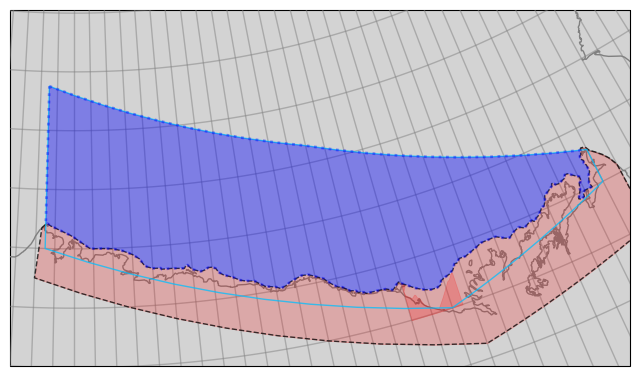

In [3]:
# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([202,232,69,73.25], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')
add_coast(ax, scale='10m', color='gray', linewidth=1, alpha=1, zorder=5)
add_grid(ax, lats=np.arange(65,90,1), lons=np.arange(120,300,1), linewidth=1, color='gray', alpha=0.5, zorder=6)
    
    
# merge regional mask polygons to subtract from main coast polygon 
#-----------------------------------------------------------------
merged_mask = poly_mask_dict['R2']['polygon'].union(poly_mask_dict['R1']['polygon'])
merged_mask
masked_coast_polygon = poly_dict['coast']['polygon'].difference(merged_mask)

# plot the polygons
#------------------
ax.add_geometries([poly_mask_dict['R2']['polygon']], edgecolor='red', linestyle='solid', facecolor='red', lw=0.5, alpha=0.2, crs= ccrs.PlateCarree(), zorder=10)
ax.add_geometries([poly_mask_dict['R1']['polygon']], edgecolor='red', linestyle='solid', facecolor='red', lw=0.5, alpha=0.2, crs= ccrs.PlateCarree(), zorder=10)
  
ax.add_geometries([merged_mask], edgecolor='k', linestyle='dashed', facecolor='None',
                  alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)

ax.add_geometries([poly_dict['coast']['polygon']], edgecolor='deepskyblue', linestyle='solid', facecolor='None',alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)
ax.add_geometries([masked_coast_polygon], edgecolor='blue', linestyle='dotted', facecolor='blue',alpha=0.4, lw=2, crs= ccrs.PlateCarree(), zorder=10)

area = abs(geod.geometry_area_perimeter(masked_coast_polygon)[0])
print(f'Geodesic coastal polygon area: {area/(1000*1000):.3f} km^2')
    

In [4]:
# open elevation data
ds_elv = xr.open_dataset('/Volumes/Jewell_EasyStore/AcrticBathymetry_IBCAO_2022/gebco_2022_n90.0_s60.0_w0.0_e360.0.nc')
ds_elv.close()
ds_lon, ds_lat = np.meshgrid(ds_elv.lon.values, ds_elv.lat.values)
elevat = ds_elv.elevation.values


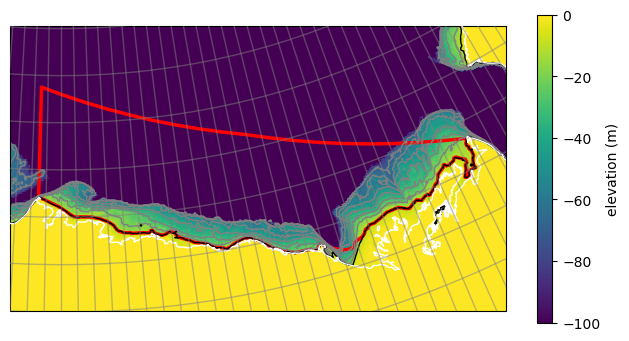

In [5]:
# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([202,232,69,73.25], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')
add_coast(ax, scale='10m', color='white', linewidth=1, alpha=1, zorder=5)
add_grid(ax, lats=np.arange(65,90,1), lons=np.arange(120,300,1), linewidth=1, color='gray', alpha=0.5, zorder=6)
    
    
# plot the polygons
#------------------
ax.add_geometries([masked_coast_polygon], edgecolor='r', linestyle='solid', facecolor='None',alpha=1,lw=2.5, crs= ccrs.PlateCarree(), zorder=1)

# bathymetry contours
sp = 10
el = ax.pcolormesh(ds_lon[::sp, ::sp], ds_lat[::sp, ::sp], elevat[::sp, ::sp], 
              cmap='viridis', vmin=-100, vmax=0, transform=ccrs.PlateCarree(), zorder=0)
fig.colorbar(el, label='elevation (m)', shrink=0.5)
ax.contour(ds_lon[::sp, ::sp], ds_lat[::sp, ::sp], ma.masked_where(ds_lat[::sp, ::sp]<69, 
                                                   ma.masked_where(ds_lon[::sp, ::sp]>240, 
                                                   ma.masked_where(ds_lon[::sp, ::sp]<200, elevat[::sp, ::sp]))), 
           linewidths=1,colors=['gray','gray','gray','gray','gray','gray', 'black'], 
           levels= [-70, -60, -50,-40,-30, -20, -10], transform=ccrs.PlateCarree(), zorder=2)
  


## Save SBS coast polygon to file

In [6]:
# OUTPUT_FILE = './data/coast_mask_regions.nc'


# ds = xr.Dataset(
#         data_vars=dict(
#             R2_lon=(poly_mask_dict['R2']['lon']),
#             R2_lat=(poly_mask_dict['R2']['lat']),
#             R2_poly_str=(str(poly_mask_dict['R2']['polygon'])),
#             R1_lon=(poly_mask_dict['R1']['lon']),
#             R1_lat=(poly_mask_dict['R1']['lat']),
#             R1_poly_str=(str(poly_mask_dict['R1']['polygon'])),   
#             coast_poly_lon=(poly_dict['coast']['lon']),
#             coast_poly_lat=(poly_dict['coast']['lat']),
#             coast_poly_str=(str(poly_dict['coast']['polygon'])),
#             coast_poly_masked_str=(str(masked_coast_polygon)),   
#         ),
#         attrs=dict(description="masked region polygons"),
#     )

# ds


# ds.to_netcdf(path=OUTPUT_FILE, 
#              mode='w', format="NETCDF4")    

## Plot example day SIC data

In [6]:


# date = datetime(year = 2020, month = 2, day = 19)
date = datetime(year = 2022, month = 11, day = 15)


# open SIC data
#--------------
out = grab_SIC_MODISAMSR(date=date, file_datapath='/Volumes/Seagate_Jewell/KenzieStuff/UniB-ASI-modis-amsr2-SIC/', 
                         file_name=f'{date.year}'+'/sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_{}.nc', 
                         geo_file='coordinates_npstere_1km_arctic.nc', return_vars=['lon', 'lat', 'sic_merged', 'xx', 'yy', 'proj'])
lon, lat, sic_merge, xx, yy, ice_projection = out[0], out[1], out[2], out[3], out[4], out[5]


# (lon, lat, sic_merge, xx, yy, ice_projection) = grab_ASI_SIC(date=date, 
#                                                              resolution='6250',
# #                                                              coord_file='LongitudeLatitudeGrid-n3125-Arctic3125.hdf',
#                                        main_path='/Volumes/Jewell_EasyStore/UniB-ASI-SIC-n6250/', 
#                                        return_vars=['lon', 'lat', 'sic', 'xx', 'yy', 'proj'], 
#                                        include_units=False, annual_folders=True, return_dict=False, quiet=True)
        
    

sp = 4
SIC_merge = sic_merge[::sp,::sp]
LON, LAT = lon[::sp, ::sp], lat[::sp, ::sp]
XX, YY = xx[::sp,::sp], yy[::sp,::sp]

# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([200,235,68,75], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')
add_coast(ax, scale='10m', color='gray', linewidth=1, alpha=1, zorder=3)
add_date(fig, ax, f'{date.strftime("%m")}/{date.strftime("%d")}/{date.year}', 
         method='anchor', boxstyle='round,pad=0.,rounding_size=0.2', 
         facecolor='black', edgecolor='black', zorder=10, anchor_loc=4, 
         anchor_prop={'size': 15, 'color': 'white'})

# plot SIC
#---------
SIC_mesh = ax.pcolormesh(LON, LAT, ma.masked_where(SIC_merge>100, SIC_merge), 
              cmap='Blues_r', vmin=80, vmax=100, transform=ccrs.PlateCarree(), zorder=2)
ax.contour(XX, YY, ma.masked_where(SIC_merge>100, SIC_merge), 
           levels=[80], linewidths = 1, colors='gold', transform=ice_projection, zorder=5)

# plot the polygons
#------------------
for poly in poly_mask_dict.keys():    
    ax.add_geometries([poly_mask_dict[poly]['polygon']], edgecolor='k', linestyle='dashed', facecolor='lightgray',alpha=0.75, crs= ccrs.PlateCarree(), zorder=11)


ax.add_geometries([poly_dict['coast']['polygon']], edgecolor='k', linestyle='solid', facecolor='none',alpha=0.75, crs= ccrs.PlateCarree(), zorder=11)


add_colorbar(fig, ax, [SIC_mesh], cb_placement='bottom', cb_orientation='horizontal', cb_width='auto', 
         cb_length_fraction=[0.6, 1], cb_pad=0.025, cb_ticks=[90,95,100],
         cb_label='SIC', labelpad='auto', cb_label_placement='auto')

#     fig.savefig(main_path+f"images/SIC_AmsrModis_SIDEx_{year}{monthday}.png",
#                     bbox_inches="tight", pad_inches = 0, dpi=300)

#     plt.close(fig)

plt.show()



AssertionError: "2022/sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_20221115.nc" not an existing file in /Volumes/Seagate_Jewell/KenzieStuff/UniB-ASI-modis-amsr2-SIC/

## Crop considered SIC data for final bulk run

/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


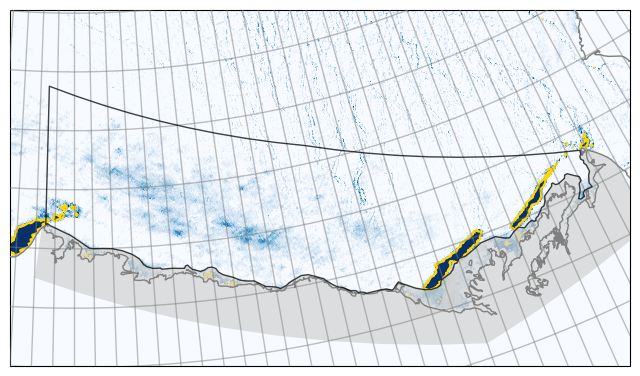

In [7]:
# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([202,232,69,73.25], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')


date = datetime(year = 2021, month = 3, day = 30)

# open SIC data
#--------------
out = grab_SIC_MODISAMSR(date=date, 
                         file_datapath='/Volumes/Seagate_Jewell/KenzieStuff/SIC_MODIS_AMSR2/', 
                         file_name=f'{date.year}'+'/sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_{}.nc', 
                         geo_file='coordinates_npstere_1km_arctic.nc', 
                         return_vars=['lon', 'lat', 'sic_merged', 'unc_sic_merged'])
lon_sic, lat_sic, sic_sic, sic_unc = out[0], out[1], out[2], out[3]


# (lon_sic, lat_sic, sic_sic) = grab_ASI_SIC(date=date, resolution='6250',
# #                                            coord_file='LongitudeLatitudeGrid-n3125-Arctic3125.hdf',
#                                        main_path='/Volumes/Jewell_EasyStore/UniB-ASI-SIC-n6250/', 
#                                        return_vars=['lon', 'lat', 'sic'], 
#                                        include_units=False, annual_folders=True, return_dict=False, quiet=True)
        
    

# # whole coast, narrow
# ai = 2200 # right edge
# af = -1500
# bi = 400
# bf = -4550 # top edge

# lon_sic_c = lon_sic[ai:af, bi:bf]
# lat_sic_c = lat_sic[ai:af, bi:bf]
# sic_sic_c = sic_sic[ai:af, bi:bf]
# sic_unc_c = sic_unc[ai:af, bi:bf]

lon_sic_c = lon_sic
lat_sic_c = lat_sic
sic_sic_c = sic_sic

SIC_mesh = ax.pcolormesh(lon_sic_c, lat_sic_c, sic_sic_c, cmap='Blues_r', vmin=80, vmax=100, transform=ccrs.PlateCarree(), zorder=2)
ax.contour(lon_sic_c, lat_sic_c, sic_sic_c, 
           levels=[80], colors=['gold'], transform=ccrs.PlateCarree(), zorder=2)

add_coast(ax, scale='10m', color='gray', linewidth=1, alpha=1, zorder=5)
add_grid(ax, lats=np.arange(65,90,1), lons=np.arange(120,300,1), linewidth=1, color='gray', alpha=0.5, zorder=6)


# plot the polygons
#------------------
ax.add_geometries([masked_coast_polygon], edgecolor='k', linestyle='solid', facecolor='None',alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)

    
# plot the polygons
#------------------
for poly in poly_mask_dict.keys():    
    ax.add_geometries([poly_mask_dict[poly]['polygon']], edgecolor='none', linestyle='dashed', facecolor='lightgray',
                      alpha=0.75, crs= ccrs.PlateCarree(), zorder=4)



## Find indices of SIC data within SBS polygon

In [8]:
# below is the time-intensive portion!
#-------------------------------------

# add within-polygon indicies of lat/lon coords to dict
poly_indices = within_polygon_indices(masked_coast_polygon, lat_sic_c, lon_sic_c, quiet=True)

# remove indices masked as land (SIC=127)
#----------------------------------------
pp_remove = np.array([])
pp_keep = np.array([])

# remove land mask values (sic=127) to save time when runnning later
for pp in range(len(poly_indices)):
    ii = int(poly_indices[pp][0])
    jj = int(poly_indices[pp][1])
    if sic_sic_c[ii,jj] == 127:
        pp_remove = np.append(pp_remove, poly_indices[pp])
    else:
        pp_keep = np.append(pp_keep, poly_indices[pp])
        
pp_keep = np.reshape(pp_keep.astype(int), (int(len(pp_keep)/2), 2))
pp_remove = np.reshape(pp_remove.astype(int), (int(len(pp_remove)/2), 2))    
print(f'remove {100*len(pp_remove)/len(poly_indices):.2f}% of polygon points which are masked as land in the SIC data')

# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([202,232,69,72.5], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')

for pp in range(len(pp_keep))[::200]:
    ii = int(pp_keep[pp][0])
    jj = int(pp_keep[pp][1])
    ax.scatter(lon_sic_c[ii,jj], lat_sic_c[ii,jj], c='white', transform=ccrs.PlateCarree())
    
for pp in range(len(pp_remove))[::10]:
    ii = int(pp_remove[pp][0])
    jj = int(pp_remove[pp][1])
    ax.scatter(lon_sic_c[ii,jj], lat_sic_c[ii,jj], transform=ccrs.PlateCarree())

ax.coastlines()

poly_pack_indices = pp_keep

KeyboardInterrupt: 

In [9]:
within_poly = np.full(np.shape(lon_sic_c), False)
for ii in range(np.shape(lon_sic_c)[0]):
    for jj in range(np.shape(lon_sic_c)[1]):
        
        if lon_sic_c[ii,jj] > 180:
            lon = lon_sic_c[ii,jj] - 360
        else:
            lon = lon_sic_c[ii,jj]
        if masked_coast_polygon.contains(Point(lon, lat_sic_c[ii,jj])):
            within_poly[ii,jj] = True
            

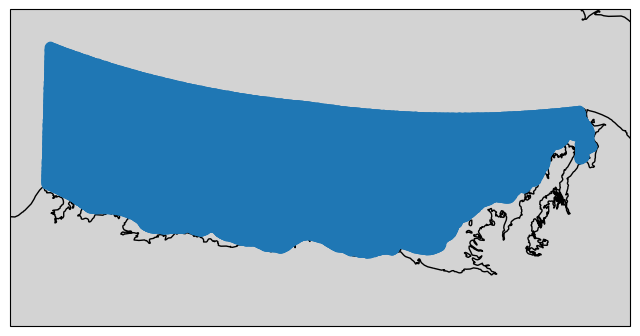

In [10]:
# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([202,232,69,72.5], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')
ax.coastlines()

ax.scatter(lon_sic_c[within_poly], lat_sic_c[within_poly], transform=ccrs.PlateCarree())

### find all the sic values (and uncertainties) in the polygon for given day

In [12]:
# find all values of sic within polygon
all_poly_sic = np.array([])
all_poly_unc = np.array([])

for pp in range(len(poly_pack_indices)):
    
    ii = int(poly_pack_indices[pp][0])
    jj = int(poly_pack_indices[pp][1])
    
    all_poly_sic = np.append(all_poly_sic, sic_sic_c[ii,jj])
    all_poly_unc = np.append(all_poly_unc, sic_unc_c[ii,jj])

print(date)

NameError: name 'sic_unc_c' is not defined

### plot

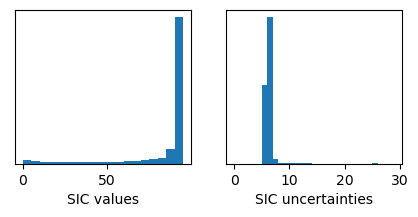

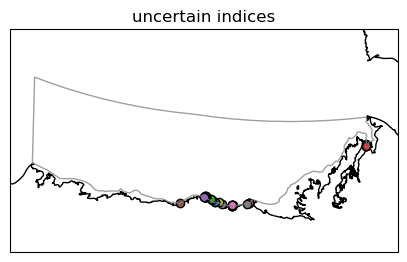

Text(0.5, 0, 'Open water concentrations')

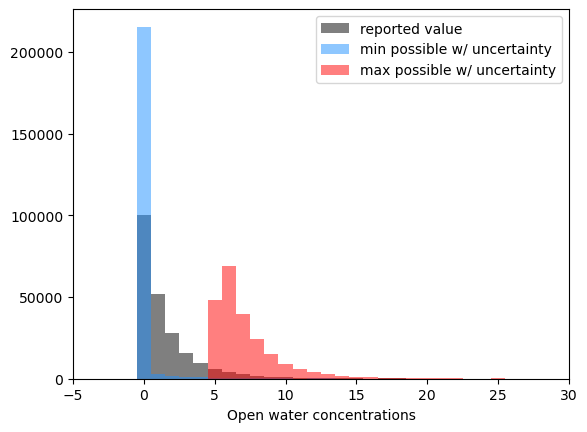

In [11]:
fig, axs = plt.subplots(1,2, figsize=(5,2))
axs[0].hist(all_poly_sic, bins=np.arange(0,100,5))
axs[0].set_yticks([])
axs[0].set_xlabel('SIC values')
axs[1].hist(all_poly_unc, bins=np.arange(0,30,1))
axs[1].set_yticks([])
axs[1].set_xlabel('SIC uncertainties')
# approximate area of open water 
# taking SIC <= 80 as open 
# and using NSIDC 1 km stereo grid as approx 1 km per pixel
# open_area = np.sum(all_poly_sic <= 80) # sq. km


#///////////////
# uncertainty
#//////////////
# all pp index values where uncertainty is high
uncertain_indices = np.where(np.logical_or((all_poly_unc > 100),(all_poly_sic > 100))==True)[0]
certain_indices = np.where(np.logical_and((all_poly_unc <= 100), (all_poly_sic <= 100)))[0]
    
# plot
#-----
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=205)), figsize=(5,3))
ax.set_extent([202,232,69,73.25], crs=ccrs.PlateCarree());
ax.coastlines()
ax.add_geometries([masked_coast_polygon], edgecolor='gray', linestyle='solid', facecolor='None',alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)
for pp in uncertain_indices:
    ii, jj = int(poly_pack_indices[pp][0]), int(poly_pack_indices[pp][1])
    ax.scatter(lon_sic_c[ii, jj], lat_sic_c[ii, jj], edgecolor='k',  transform=ccrs.PlateCarree())
ax.set_title('uncertain indices')
plt.show()


# open water concentration (0-100)
# fill values of sic = 101 will be negative. Neglect these
owc = 100 - all_poly_sic

# find values from estimated uncertainty range
owc_min = 100 - (all_poly_sic+all_poly_unc)
owc_max = 100 - (all_poly_sic-all_poly_unc)

# crop to physical ranges
owc_min[owc_min<0] = 0
owc_max[owc_max>100] = 100

plt.hist(owc, bins=np.arange(-10.5,30.5,1), color = 'black', alpha=0.5,label='reported value')
plt.hist(owc_min, bins=np.arange(-10.5,30.5,1), color = 'dodgerblue',alpha=0.5, label='min possible w/ uncertainty')
plt.hist(owc_max, bins=np.arange(-10.5,30.5,1), color = 'red', alpha=0.5,label='max possible w/ uncertainty')
plt.xlim(-5,30)
plt.legend()
plt.xlabel('Open water concentrations')


In [62]:
ds = xr.open_dataset('/Volumes/Jewell_EasyStore/UniB-ASI-SIC-n6250/PolStereo_GridCellArea_n6.25km_Arctic.nc')
ds.close()

cell_area = ds.data.values #sq. km

local_area = cell_area[within_poly]

# Run over all of 2020-2021 growth season

In [11]:
dates = np.array([])

doa = np.array([])
oa = np.array([])
N_abv10 = np.array([])
ext_abov10 = np.array([])
oa_abv10 = np.array([])

N_abv20 = np.array([])
ext_abov20 = np.array([])
oa_abv20 = np.array([])

oa_inc20 = np.array([])
opinga_inc = np.array([])
opinga_inc05 = np.array([])
opinga_inc10 = np.array([])
opinga_inc20 = np.array([])


months = ['11', '12', '01', '02', '03', '04', '05',
         '11', '12', '01', '02', '03', '04', '05',
         '11', '12', '01', '02', '03', '04', '05',
         '11', '12', '01', '02', '03', '04', '05',
         '11', '12', '01', '02', '03', '04', '05',
         '11', '12', '01', '02', '03', '04', '05',
         '11', '12', '01', '02', '03', '04', '05']
years = ['2017', '2017', '2018', '2018', '2018', '2018', '2018',
         '2018', '2018', '2019', '2019', '2019', '2019', '2019',
         '2019', '2019', '2020', '2020', '2020', '2020', '2020',
         '2020', '2020', '2021', '2021', '2021', '2021', '2021',
         '2021', '2021', '2022', '2022', '2022', '2022', '2022',
         '2022', '2022', '2023', '2023', '2023', '2023', '2023',
         '2023', '2023', '2024', '2024', '2024', '2024', '2024']

# 6.25 km product
# local_area = cell_area[within_poly]

# 1 km product
local_area = 1   

counter = 0 

for yy, year in enumerate(years):
    
    month = months[yy]
    print(f'\n{year} - {month}\n----')
    
    # run through all days each month
    days_in_month = calendar.monthrange(int(year), int(month))[1]
    
    
    for day in np.arange(1,days_in_month+1):
        
        if day%15==0:
            print(day)
        
        # save date
        date = datetime(year = int(year), month = int(month), day = day)
        dates = np.append(dates, date)
        
        
        if counter == 0:
            
            # open SIC from PREVIOUS date
            date2 = date - timedelta(days=1)
            #--------------
#             sic_previous = grab_ASI_SIC(date=date, resolution='6250',
# #                                         coord_file='LongitudeLatitudeGrid-n3125-Arctic3125.hdf',
#                                        main_path='/Volumes/Jewell_EasyStore/UniB-ASI-SIC-n6250/', 
#                                        return_vars=['sic'], 
#                                        include_units=False, annual_folders=True, return_dict=False, quiet=True)
#             sic_prev_c = sic_previous.astype(float)
#             sic_prev_c[sic_prev_c>100] = np.nan
        
            sic_previous = grab_SIC_MODISAMSR(date=date2, 
                                     file_datapath='/Volumes/Seagate_Jewell/KenzieStuff/UniB-ASI-modis-amsr2-SIC/', 
                                     file_name=f'{year}/'+'sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_{}.nc', 
                                     geo_file='coordinates_npstere_1km_arctic.nc', 
                                     return_vars=['sic_merged'])
            
            sic_prev_c = sic_previous.astype(float)
#             sic_prev_c = sic_previous[ai:af, bi:bf].astype(float)
            sic_prev_c[sic_prev_c>100] = np.nan
            
            # find open water area
            #---------------------
            # grab all sic values in polygon
#             all_poly_prev = np.array([]) #######
#             for pp in range(len(poly_pack_indices)):
#                 ii = int(poly_pack_indices[pp][0])
#                 jj = int(poly_pack_indices[pp][1])
#                 all_poly_prev = np.append(all_poly_prev, sic_prev_c[ii,jj]) #######
                
            all_poly_prev = sic_prev_c[within_poly]
            
        else:
            all_poly_prev = all_poly_sic
              
            
        # open SIC data
        #--------------
        
        try:
        
            sic_merge = grab_SIC_MODISAMSR(date=date, 
                                     file_datapath='/Volumes/Seagate_Jewell/KenzieStuff/UniB-ASI-modis-amsr2-SIC/', 
                                     file_name=f'{year}/'+'sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_{}.nc', 
                                     geo_file='coordinates_npstere_1km_arctic.nc', 
                                     return_vars=['sic_merged'])
            sic_sic_c = sic_merge.astype(float)
    #         sic_sic_c = sic_merge[ai:af, bi:bf].astype(float)
            sic_sic_c[sic_sic_c>100] = np.nan

        except:
            sic_sic_c = np.full_like(sic_prev_c, np.nan)
            
#         sic_merge = grab_ASI_SIC(date=date, resolution='6250',
# #                                         coord_file='LongitudeLatitudeGrid-n3125-Arctic3125.hdf',
#                                        main_path='/Volumes/Jewell_EasyStore/UniB-ASI-SIC-n6250/', 
#                                        return_vars=['sic'], 
#                                        include_units=False, annual_folders=True, return_dict=False, quiet=True)
#         sic_sic_c = sic_merge.astype(float)
#         sic_sic_c[sic_sic_c>100] = np.nan
        
        # find open water area
        #---------------------
        # grab all sic values in polygon
#         all_poly_sic = np.array([])
        
#         for pp in range(len(poly_pack_indices)):
#             ii = int(poly_pack_indices[pp][0])
#             jj = int(poly_pack_indices[pp][1])
#             all_poly_sic = np.append(all_poly_sic, sic_sic_c[ii,jj])
            
            
        all_poly_sic = sic_sic_c[within_poly]
            
        if np.sum(np.isfinite(sic_sic_c[within_poly])) == 0:
            
            doa = np.append(doa, np.nan)
            oa = np.append(oa, np.nan)
            opinga_inc = np.append(opinga_inc, np.nan)
            opinga_inc20 = np.append(opinga_inc20, np.nan)
            oa_inc20 = np.append(oa_inc20, np.nan)
            
            N_abv20 = np.append(N_abv20, np.nan)
            ext_abov20 = np.append(ext_abov20, np.nan)
            oa_abv20 = np.append(oa_abv20, np.nan)
            N_abv10 = np.append(N_abv10, np.nan)
            ext_abov10 = np.append(ext_abov10, np.nan)
            oa_abv10 = np.append(oa_abv10, np.nan)
            

        else:
            
            # open water concentration (0-100)
            # fill values of sic = 101 will be negative. Neglect these
            owc_i = (100 - all_poly_prev)
            owc_f = (100 - all_poly_sic)

            # make them share all nan values
            owc_f[np.isnan(owc_i)] = np.nan
            owc_i[np.isnan(owc_f)] = np.nan

            # change in open water concentration
            doc = owc_f - owc_i

            # total area change
            open_area_change = np.nansum( (doc*local_area) / 100 )
            doa = np.append(doa, open_area_change)

            # total open area
            open_area = np.nansum(owc_f*local_area/100)
            oa = np.append(oa, open_area)

            # new open area for cells with increase opening
            opening_inc = np.nansum(local_area*doc[doc>0]/100)
            opinga_inc = np.append(opinga_inc, opening_inc)

            # new open area for cells with increase of 10% opening
            opening_inc05 = np.nansum(local_area*doc[doc>5]/100)
            opinga_inc05 = np.append(opinga_inc05, opening_inc05)

            # new open area for cells with increase of 10% opening
            opening_inc10 = np.nansum(local_area*doc[doc>10]/100)
            opinga_inc10 = np.append(opinga_inc10, opening_inc10)

            # new open area for cells with increase of 20% opening
            opening_inc20 = np.nansum(local_area*doc[doc>20]/100)
            opinga_inc20 = np.append(opinga_inc20, opening_inc20)

            # open area for cells with new opening
            oa_increase20 = np.nansum(local_area*owc_f[doc>20]/100)
            oa_inc20 = np.append(oa_inc20, oa_increase20)


            # sum cells with open water area of 10% concentration or higher
            num_above_10 = np.nansum(owc_f>10)
            N_abv10 = np.append(N_abv10, num_above_10)

            extent_above_10 = np.nansum(owc_f>10)#np.nansum(local_area[owc_f>10])
            ext_abov10 = np.append(ext_abov10, extent_above_10)

            # total open area for areas with sic < 90 or open area > 10
            open_above_10 = np.nansum(local_area*owc_f[owc_f>10]/100)
            oa_abv10 = np.append(oa_abv10, open_above_10)

            # sum cells with open water area of 20% concentration or higher
            num_above_20 = np.nansum(owc_f>20)
            N_abv20 = np.append(N_abv20, num_above_20)


            extent_above_20 = np.nansum(owc_f>20)#np.nansum(local_area[owc_f>20])
            ext_abov20 = np.append(ext_abov20, extent_above_20)


            # total open area for areas with sic < 80 or open area > 20
            open_above_20 = np.nansum(owc_f[owc_f>20]/100)
            oa_abv20 = np.append(oa_abv20, open_above_20)

        counter+=1
        
        


2017 - 11
----
15
30

2017 - 12
----
15
30

2018 - 01
----
15
30

2018 - 02
----
15

2018 - 03
----
15
30

2018 - 04
----
15
30

2018 - 05
----
15
30

2018 - 11
----
15
30

2018 - 12
----
15
30

2019 - 01
----
15
30

2019 - 02
----
15

2019 - 03
----
15
30

2019 - 04
----
15
30

2019 - 05
----
15
30

2019 - 11
----
15
30

2019 - 12
----
15
30

2020 - 01
----
15
30

2020 - 02
----
15

2020 - 03
----
15
30

2020 - 04
----
15
30

2020 - 05
----
15
30

2020 - 11
----
15
30

2020 - 12
----
15
30

2021 - 01
----
15
30

2021 - 02
----
15

2021 - 03
----
15
30

2021 - 04
----
15
30

2021 - 05
----
15
30

2021 - 11
----
15
30

2021 - 12
----
15
30

2022 - 01
----
15
30

2022 - 02
----
15

2022 - 03
----
15
30

2022 - 04
----
15
30

2022 - 05
----
15
30

2022 - 11
----
15
30

2022 - 12
----
15
30

2023 - 01
----
15
30

2023 - 02
----
15

2023 - 03
----
15
30

2023 - 04
----
15
30

2023 - 05
----
15
30

2023 - 11
----
15
30

2023 - 12
----
15
30

2024 - 01
----
15
30

2024 - 02
----
15

2024 - 0

In [81]:
sic_sic_c = np.full_like(sic_prev_c, np.nan)

In [85]:
np.sum(np.isfinite(sic_sic_c[within_poly]))

0

## Plot results

(-500.0, 22000.0)

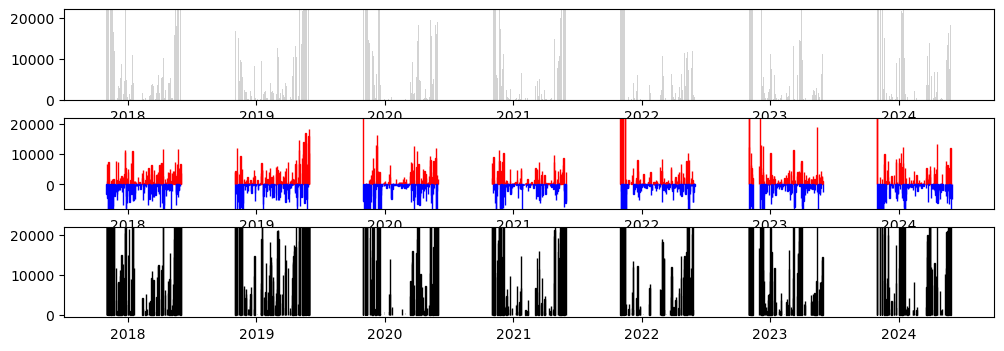

In [12]:
fig, axs = plt.subplots(3,1, figsize=(12,4))

axs[0].bar(dates, oa_abv20, color='lightgray')
axs[0].set_ylim(-10,22000)

axs[1].bar(dates, doa, color='lightgray')
axs[1].bar(dates[doa>0], doa[doa>0], facecolor='none', edgecolor='red')
axs[1].bar(dates[doa<=0], doa[doa<=0], facecolor='none', edgecolor='blue')
axs[1].set_ylim(-8000,22000)


cond = (np.diff(N_abv20)>0)&(N_abv20[1:]>1000)
plt.bar(dates, N_abv20, color='lightgray')
axs[2].bar(dates[1:][cond], N_abv20[1:][cond], facecolor='none', edgecolor='k')
# axs[2].bar(dates, N_abv20, color='r', alpha=0.5)
axs[2].set_ylim(-500,22000)

(-500.0, 22000.0)

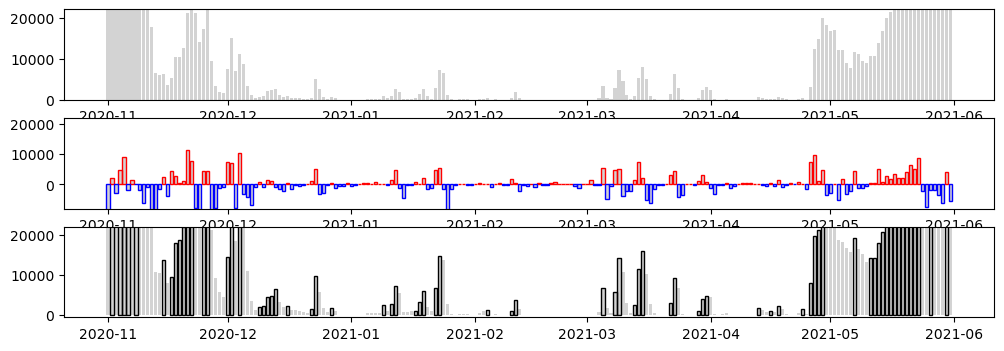

In [13]:
fig, axs = plt.subplots(3,1, figsize=(12,4))

axs[0].bar(dates, oa_abv20, color='lightgray')
axs[0].set_ylim(-10,22000)

axs[1].bar(dates, doa, color='lightgray')
axs[1].bar(dates[doa>0], doa[doa>0], facecolor='none', edgecolor='red')
axs[1].bar(dates[doa<=0], doa[doa<=0], facecolor='none', edgecolor='blue')
axs[1].set_ylim(-8000,22000)


cond = (np.diff(N_abv20)>0)&(N_abv20[1:]>1000)
plt.bar(dates, N_abv20, color='lightgray')
axs[2].bar(dates[1:][cond], N_abv20[1:][cond], facecolor='none', edgecolor='k')
# axs[2].bar(dates, N_abv20, color='r', alpha=0.5)
axs[2].set_ylim(-500,22000)


# Save data

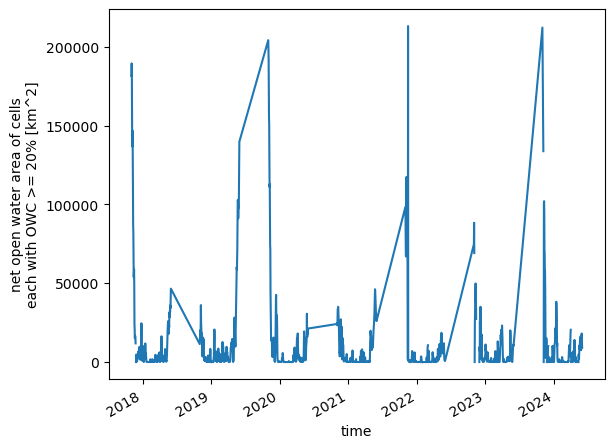

In [13]:
# OUTPUT_FILE = './data/SBS_open_area_20182024_1km2.nc'


# ds = xr.Dataset(
#         data_vars=dict(
#             doa=(["time"], doa, {"long_name": "daily change in net open water area", "units": "km^2"}),
#             oa = (["time"], oa, {"long_name": "net open water area", "units": "km^2"}),
#             noa_inc = (["time"], opinga_inc, {"long_name": "net new open water area of cells with increase open area", "units": "km^2"}),
#             noa_inc_g20 = (["time"], opinga_inc20, {"long_name": "net new open water area of cells with daily increased OWC >= 20%", "units": "km^2"}),
#             oa_inc_g20 = (["time"], oa_inc20, {"long_name": "net open water area of cells with daily increased OWC >= 20%", "units": "km^2"}),
            
#             N_oa_g20 = (["time"], N_abv20, {"long_name": "# of 1 km^2 cells with OWC >= 20%", "units": "km^2"}),
#             ext_g20 = (["time"], ext_abov20, {"long_name": "open water extent across cells with OWC >= 20%", "units": "km^2"}),
#             oa_g20 = (["time"], oa_abv20, {"long_name": "net open water area of cells each with OWC >= 20%", "units": "km^2"}),
#             N_oa_g10 = (["time"], N_abv10, {"long_name": "# of 1 km^2 cells with OWC >= 10%", "units": "km^2"}),
#             ext_g10 = (["time"], ext_abov10, {"long_name": "open water extent across cells with OWC >= 10%", "units": "km^2"}),
#             oa_g10 = (["time"], oa_abv10, {"long_name": "net open water area of cells each with OWC >= 10%", "units": "km^2"})
            
#         ),
#         coords=dict(time = (["time"], dates)),
#         attrs=dict(description="open area in coastal polygon"),
#     )

# ds.oa_g20.plot()


# ds.to_netcdf(path=OUTPUT_FILE, 
#              mode='w', format="NETCDF4")    

## Ice drift within region

/Users/mackenziejewell/Documents/GitHub/SIDEx-MYI-transport_rev/./scripts/LIB_PPdrift_NSIDC0116.py:406: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()


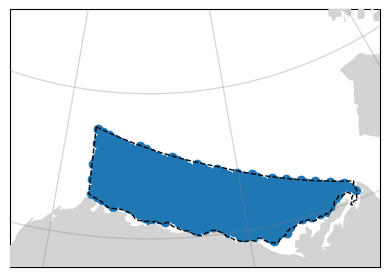

In [10]:

out = grab_icedrift_range(start_date=datetime(2000,1,1), 
                    end_date=datetime(2000,1,2), 
                    PPD_drift_path='/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/', 
                    PPD_filename='icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
                    return_vars=['lon', 'lat', 'proj', 'ds', 'xx', 'yy'], 
                    lat_range=[0, 90], lon_range=[0, 360])
dft_lons = out[0]
dft_lats = out[1]

xx = out[4]
yy = out[5]
dx = np.diff(xx, axis=1)
dy = np.diff(yy, axis=0)
    
dft_within_poly = np.full(np.shape(dft_lons), False)
for ii in range(np.shape(dft_lons)[0]):
    for jj in range(np.shape(dft_lons)[1]):
        
        if dft_lons[ii,jj] > 180:
            lon = dft_lons[ii,jj] - 360
        else:
            lon = dft_lons[ii,jj]
        if masked_coast_polygon.contains(Point(lon, dft_lats[ii,jj])):
            dft_within_poly[ii,jj] = True
            

            
# set map extent, add grid and geo features
#------------------------------------------
map_projection = ccrs.NorthPolarStereo(central_longitude=210)
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True, subplot_kw = {'projection':map_projection})
lat_range = [68.5, 77]
lon_range = [197, 232]
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
add_land(ax,  scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=16)
add_grid(ax, lats=np.arange(70,90,5), lons=np.arange(100,300,20), linewidth=1, color='gray', alpha=0.3, zorder=18)

# polygons
#---------
ax.add_geometries([masked_coast_polygon], edgecolor='k', linestyle='dashed', facecolor='none',
                  alpha=1, lw=1,  crs= ccrs.PlateCarree(), zorder=10)

ax.scatter(dft_lons[dft_within_poly], dft_lats[dft_within_poly], transform=ccrs.PlateCarree())
    

### ERA points within polygon

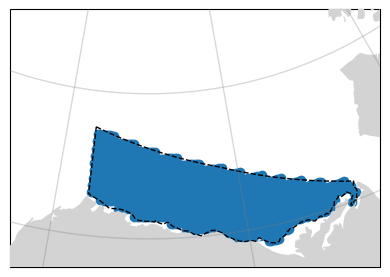

In [7]:
dsERA = xr.open_dataset('/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_2021_daily.nc')
dsERA.close()

era_lons = dsERA.longitude.values
era_lats = dsERA.latitude.values

era_within_poly = np.full((len(era_lats), len(era_lons)), False)

for ii in range(len(era_lats)):
    for jj in range(len(era_lons)):
        
        if era_lons[jj] > 180:
            lon = era_lons[jj] - 360
        else:
            lon = era_lons[jj]
        if masked_coast_polygon.contains(Point(lon, era_lats[ii])):
            era_within_poly[ii,jj] = True
            
longrid,latgrid = np.meshgrid(era_lons, era_lats)
weights = np.cos(np.deg2rad(latgrid))

# set map extent, add grid and geo features
#------------------------------------------
map_projection = ccrs.NorthPolarStereo(central_longitude=210)
fig, ax = plt.subplots(figsize=(4,4), tight_layout=True, subplot_kw = {'projection':map_projection})
lat_range = [68.5, 77]
lon_range = [197, 232]
ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]], crs=ccrs.PlateCarree())  
add_land(ax,  scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=16)
add_grid(ax, lats=np.arange(70,90,5), lons=np.arange(100,300,20), linewidth=1, color='gray', alpha=0.3, zorder=18)

# polygons
#---------
ax.add_geometries([masked_coast_polygon], edgecolor='k', linestyle='dashed', facecolor='none',
                  alpha=1, lw=1,  crs= ccrs.PlateCarree(), zorder=10)

ax.scatter(longrid[era_within_poly], latgrid[era_within_poly], transform=ccrs.PlateCarree())
    

In [12]:
import metpy.calc as mpcalc

years = np.arange(2018, 2023)

all_u = np.array([])
all_v = np.array([])
all_sp = np.array([])
all_div = np.array([])

all_u10 = np.array([])
all_v10 = np.array([])
all_sp10 = np.array([])

counter = 0

for year in years:

    print(year)
    
    # PPD
    #======
    
    # before Jan 1
    #-------------
#     dates = pd.to_datetime(pd.date_range(datetime(year-1, 11, 1, 0, 0), datetime(year-1, 12, 31, 0, 0)))
#     out = grab_icedrift_range(start_date=dates[0], end_date=dates[-1], return_vars=['u', 'v'])
#     u = out[0]
#     v = out[1]
#     sp = np.sqrt(u**2+v**2)

#     spatial_mean_u = np.nanmean(u[:,dft_within_poly], axis=1)
#     spatial_mean_v = np.nanmean(v[:,dft_within_poly], axis=1)
#     spatial_mean_speed = np.nanmean(sp[:,dft_within_poly], axis=1)
    
#     if counter == 0:
#         all_dates = dates
#         counter+=1
#     else:
#         all_dates = np.append(all_dates, dates)
#     all_u = np.append(all_u, spatial_mean_u)
#     all_v = np.append(all_v, spatial_mean_v)
#     all_sp = np.append(all_sp, spatial_mean_speed)
  
    # after Jan 1
    #------------
    dates = pd.to_datetime(pd.date_range(datetime(year, 1, 1, 0, 0), datetime(year, 5, 31, 0, 0)))
    out = grab_icedrift_range(start_date=dates[0], end_date=dates[-1], return_vars=['u', 'v', 'u_EASE', 'v_EASE'])
    u = out[0]
    v = out[1]
    sp = np.sqrt(u**2+v**2)
    
    u_E = out[2]
    v_E = out[3]
    # Calculate the total deformation of the flow
    div = mpcalc.divergence(u_E, v_E, dx = dx[0][0]*units('m'), dy = dy[0][0]*units('m'))


    spatial_mean_u = np.nanmean(u[:,dft_within_poly], axis=1)
    spatial_mean_v = np.nanmean(v[:,dft_within_poly], axis=1)
    spatial_mean_speed = np.nanmean(sp[:,dft_within_poly], axis=1)
    spatial_mean_div = np.nanmean(div[:,dft_within_poly], axis=1)
    
    if counter == 0:
        all_dates = dates
        counter+=1
    else:
        all_dates = np.append(all_dates, dates)
    all_u = np.append(all_u, spatial_mean_u)
    all_v = np.append(all_v, spatial_mean_v)
    all_sp = np.append(all_sp, spatial_mean_speed)
    
    all_div = np.append(all_div, spatial_mean_div)
    
    # ERA5
    #======
    dsERA = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    dsERA.close()

    dates = pd.date_range(datetime(year, 1, 1, 0, 0), datetime(year, 5, 31, 0, 0))

    current_ds = dsERA.sel(time=slice(dates[0], dates[-1]))
    
    loc_weights = weights[era_within_poly]
    loc_u = current_ds.u10.values[:,era_within_poly]
    loc_v = current_ds.v10.values[:,era_within_poly]
    loc_sp = np.sqrt(loc_u**2+loc_v**2)
    
#     (U, V) = wind_components(1. * units('cm/s'), (112.5) * units.deg)
#     u_comp = U.magnitude
#     v_comp = V.magnitude
#     local_ESE = (loc_u * u_comp + loc_v * v_comp)

    spatial_mean_u = np.nansum(loc_u * loc_weights, axis=1)/np.sum(loc_weights)
    spatial_mean_v = np.nansum(loc_v * loc_weights, axis=1)/np.sum(loc_weights)
    spatial_mean_sp = np.nansum(loc_sp * loc_weights, axis=1)/np.sum(loc_weights)
#     spatial_mean_ese = np.nansum(local_ESE * loc_weights, axis=1)/np.sum(loc_weights)

    all_u10 = np.append(all_u10, spatial_mean_u)
    all_v10 = np.append(all_v10, spatial_mean_v)
    all_sp10 = np.append(all_sp10, spatial_mean_sp)
    
    
    

# # before Jan 1
# #-------------
# year = 2023
# dates = pd.to_datetime(pd.date_range(datetime(year-1, 11, 1, 0, 0), datetime(year-1, 12, 31, 0, 0)))
# out = grab_icedrift_range(start_date=dates[0], end_date=dates[-1], return_vars=['u', 'v'])
# u = out[0]
# v = out[1]
# sp = np.sqrt(u**2+v**2)

# spatial_mean_u = np.nanmean(u[:,dft_within_poly], axis=1)
# spatial_mean_v = np.nanmean(v[:,dft_within_poly], axis=1)
# spatial_mean_speed = np.nanmean(sp[:,dft_within_poly], axis=1)


# all_dates = np.append(all_dates, dates)
# all_u = np.append(all_u, spatial_mean_u)
# all_v = np.append(all_v, spatial_mean_v)
# all_sp = np.append(all_sp, spatial_mean_speed)

2018


/Users/mackenziejewell/Documents/GitHub/SIDEx-MYI-transport_rev/./scripts/LIB_PPdrift_NSIDC0116.py:406: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()


2019


/Users/mackenziejewell/Documents/GitHub/SIDEx-MYI-transport_rev/./scripts/LIB_PPdrift_NSIDC0116.py:406: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()


2020


/Users/mackenziejewell/Documents/GitHub/SIDEx-MYI-transport_rev/./scripts/LIB_PPdrift_NSIDC0116.py:406: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()


2021


/Users/mackenziejewell/Documents/GitHub/SIDEx-MYI-transport_rev/./scripts/LIB_PPdrift_NSIDC0116.py:406: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()


2022


/Users/mackenziejewell/Documents/GitHub/SIDEx-MYI-transport_rev/./scripts/LIB_PPdrift_NSIDC0116.py:406: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ds['time'] = CFTime.to_datetimeindex()


In [90]:
len(all_dates)

1122

In [13]:
# d = {'date': all_dates, 
#      'u_ice': all_u, 
#      'v_ice': all_v, 
#      'sp_ice': all_sp,
#      'div_ice': all_div,
#     'u10': all_u10, 
#      'v10': all_v10, 
#      'sp10': all_sp10}
# df = pd.DataFrame(data=d)

# df.to_csv('./data/SBS_drift_wind_Jan-May_across-years_v1.csv')

In [ ]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/weekly_icemotion_NSDIC/icemotion_weekly_nh_25km_20230101_20240602_ql.nc')
ds.close()


In [71]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/weekly_icemotion_NSDIC/icemotion_weekly_nh_25km_20230101_20240602_ql.nc')
ds.close()


weekly_dt = np.array([(datetime.strptime(str(time),'%Y-%m-%d %H:%M:%S') - datetime(2023, 1, 1)).days for time in ds.time.values])

weekly_dt

spatial_mean_u = np.nanmean(ds.u.values[:,dft_within_poly])
spatial_mean_v = np.nanmean(ds.v.values[:,dft_within_poly])
speed = np.sqrt(ds.u.values**2+ ds.v.values**2)
spatial_mean_sp = np.nanmean(speed[:,dft_within_poly])


In [72]:
spatial_mean_u = np.nanmean(ds.u.values[:,dft_within_poly], axis=1)
spatial_mean_v = np.nanmean(ds.v.values[:,dft_within_poly], axis=1)
speed = np.sqrt(ds.u.values**2+ ds.v.values**2)
spatial_mean_sp = np.nanmean(speed[:,dft_within_poly], axis=1)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_1466/2273328087.py:1: RuntimeWarning: Mean of empty slice
  spatial_mean_u = np.nanmean(ds.u.values[:,dft_within_poly], axis=1)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_1466/2273328087.py:2: RuntimeWarning: Mean of empty slice
  spatial_mean_v = np.nanmean(ds.v.values[:,dft_within_poly], axis=1)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_1466/2273328087.py:4: RuntimeWarning: Mean of empty slice
  spatial_mean_sp = np.nanmean(speed[:,dft_within_poly], axis=1)


In [74]:
# d = {'dt': weekly_dt, 
#      'u': spatial_mean_u, 
#      'v': spatial_mean_v, 
#      'sp': spatial_mean_sp}
# df = pd.DataFrame(data=d)

# df.to_csv('./data/SBS_drift_202324_v6.csv')

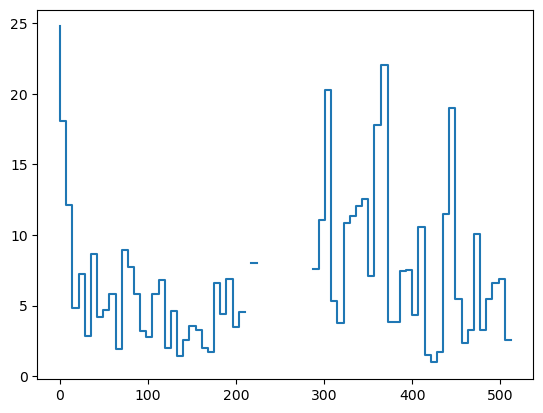

In [73]:
plt.step(weekly_dt, spatial_mean_sp)

In [67]:
spatial_mean_sp

7.1387076

In [375]:
ds5

<xarray.Dataset>
Dimensions:  (time: 2405)
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2022-04-30
Data variables:
    u        (time) float64 ...
    v        (time) float64 ...
Attributes:
    description:  ice drift in SBS polygon JFMA 2003-2022